In [1]:
import keras
import random
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.random.seed(42) # NumPy
random.seed(42) # Python
tf.random.set_seed(42) # Tensorflow

In [2]:
import optuna

# Using Reduced Data

In [3]:
train_data = pd.read_pickle('train_data_mutual_info_classif.pkl')

In [4]:
train_data.head()

ProductCD  card3  card4  card6  addr2  R_emaildomain       D12       D13   
0          4     42      1      1     65             31 -1.416108 -1.833103  \
1          4     42      2      1     65             31 -1.416108 -1.833103   
2          4     42      4      2     65             31 -1.416108 -1.833103   
3          4     42      2      2     65             31 -1.416108 -1.833103   
4          1     42      2      1     65             31 -1.217018  0.281952   

   M1  M2  M3  M4  M5  M7  M8  M9       V18       V30      V40      V60   
0   1   1   1   2   0   2   2   2 -0.540222 -0.664176 -0.50417 -0.51961  \
1   2   2   2   0   1   2   2   2 -0.540222 -0.664176 -0.50417 -0.51961   
2   1   1   1   0   0   0   0   0 -0.540222 -0.664176 -0.50417 -0.51961   
3   2   2   2   0   1   2   2   2 -0.540222 -0.664176 -0.50417 -0.51961   
4   2   2   2   3   2   2   2   2 -0.540222 -0.664176 -0.50417 -0.51961   

        V70       V80       V81       V91      V173      V174      V223   
0 -0.664404 -0.521953 -0.508172 -0.694394 -1.102703 -1.135389 -1.072947  \
1 -0.664404 -0.521953 -0.508172 -0.694394 -1.102703 -1.135389 -1.072947   
2 -0.664404 -0.521953 -0.508172 -0.694394 -1.102703 -1.135389 -1.072947   
3 -0.664404 -0.521953 -0.508172 -0.694394 -0.105190  0.854764  0.815741   
4 -0.664404 -0.521953 -0.508172 -0.694394 -1.102703 -1.135389 -1.072947   

   id_12  id_13  id_15  id_16  id_17  id_19  id_20  id_28  id_29  id_30   
0      2     54      3      2    104    522    394      2      2     74  \
1      2     54      3      2    104    522    394      2      2     74   
2      2     54      3      2    104    522    394      2      2     74   
3      2     54      3      2    104    522    394      2      2     74   
4      1     54      1      1     59    400     32      1      1      7   

   id_33  id_35  id_36  id_37  DeviceType  DeviceInfo  R_parent_domain   
0    260      2      2      2           1        1735               16  \
1    260      2      2      2           1        1735               16   
2    260      2      2      2           1        1735               16   
3    260      2      2      2           1        1735               16   
4    164      1      0      1           2         954               16   

   R_domain_name  R_top_level_domain  device_name  device_version  os_name   
0             24                   8           13             293        7  \
1             24                   8           13             293        7   
2             24                   8           13             293        7   
3             24                   8           13             293        7   
4             24                   8            7             249        0   

   os_version  TransactionAmt  isFraud  
0          68       -0.278167        0  
1          68       -0.443327        0  
2          68       -0.317889        0  
3          68       -0.355521        0  
4          58       -0.355521        0

In [5]:
# Feature selection
X = train_data.drop(['isFraud'], axis=1)
y = train_data['isFraud']

# split the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [6]:
from imblearn.over_sampling import SMOTE

In [7]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)

(729248, 51)
(729248,)


In [12]:
import optuna
from tensorflow import keras
from sklearn.metrics import roc_auc_score
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_auc_score, confusion_matrix

# Oversampled

In [13]:
def objective(trial):
    # Define the hyperparameters to optimize
    num_layers = trial.suggest_int('num_layers', 2, 4)
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [3e-7, 1e-6, 1e-5, 1e-4, 1e-3])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    layer_units = []

    # Define the number of neurons in each layer
    for i in range(num_layers):
        layer_units.append(trial.suggest_int(f'layer_{i}_units', 64, 512, step=64))

    # Define the model architecture
    model = Sequential()
    for i, units in enumerate(layer_units):
        if i == 0:
            model.add(Dense(units, activation='relu', input_shape=[X_train_smote.shape[1]]))
        else:
            model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Define optimizer with the suggested learning rate
    if optimizer == 'adam':
        opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)

    auc_metric = tf.keras.metrics.AUC(name='auc')


    # Compile the model with the specified optimizer
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=[auc_metric])

    # Define callbacks
    early_stop = EarlyStopping(patience=5, monitor='val_auc', restore_best_weights=True)

    # Train the model
    model.fit(X_train_smote, y_train_smote, batch_size=batch_size, validation_data=(X_val, y_val), epochs=50, verbose=0, callbacks=[early_stop])

    # Predict probabilities for validation set
    y_pred_proba = model.predict(X_test)
    # y_pred_binary = (y_pred_proba > 0.4).astype(int)
    # cm = confusion_matrix(y_test, y_pred_binary)

    # Calculate the AUC
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # # calculate recall and precision
    # tn, fp, fn, tp = cm.ravel()
    # recall = tp / (tp + fn)
    # precision = tp / (tp + fp)
    # print(recall)
    # print(precision)
    # Return both AUC and precision
    return auc_score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=80)


print(f"Best params: {study.best_params}")
print(f"Best value for AUC: {study.best_value}")

[I 2023-07-01 19:21:00,026] A new study created in memory with name: no-name-65226921-0027-490f-a794-4d2e19267bdc


Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-07-01 19:22:10.708541: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 19:30:39,875] Trial 0 finished with value: 0.38640480434900404 and parameters: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 1e-06, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 384, 'layer_1_units': 384, 'layer_2_units': 192}. Best is trial 0 with value: 0.38640480434900404.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 19:40:56,868] Trial 1 finished with value: 0.818660895938133 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 448, 'layer_1_units': 512}. Best is trial 1 with value: 0.818660895938133.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 20:11:48,923] Trial 2 finished with value: 0.7501335346203827 and parameters: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 256, 'layer_2_units': 384}. Best is trial 1 with value: 0.818660895938133.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 20:35:24,245] Trial 3 finished with value: 0.8100535355039883 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 384, 'layer_1_units': 64}. Best is trial 1 with value: 0.818660895938133.


2953/2953 [==============================] - 7s 2ms/step


[I 2023-07-01 20:40:41,678] Trial 4 finished with value: 0.8129461297557126 and parameters: {'num_layers': 4, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 128, 'layer_1_units': 192, 'layer_2_units': 448, 'layer_3_units': 128}. Best is trial 1 with value: 0.818660895938133.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 20:49:21,989] Trial 5 finished with value: 0.6878157282399664 and parameters: {'num_layers': 4, 'dropout_rate': 0.4, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 256, 'layer_1_units': 128, 'layer_2_units': 512, 'layer_3_units': 192}. Best is trial 1 with value: 0.818660895938133.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 20:53:16,976] Trial 6 finished with value: 0.6047728248690353 and parameters: {'num_layers': 4, 'dropout_rate': 0.4, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 64, 'layer_1_units': 256, 'layer_2_units': 192, 'layer_3_units': 64}. Best is trial 1 with value: 0.818660895938133.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 21:27:20,537] Trial 7 finished with value: 0.821437285189744 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 256, 'layer_1_units': 256}. Best is trial 7 with value: 0.821437285189744.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 21:31:20,871] Trial 8 finished with value: 0.431834528108354 and parameters: {'num_layers': 4, 'dropout_rate': 0.3, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 64, 'layer_1_units': 128, 'layer_2_units': 192, 'layer_3_units': 512}. Best is trial 7 with value: 0.821437285189744.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 21:37:32,731] Trial 9 finished with value: 0.8110753211293856 and parameters: {'num_layers': 3, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 384, 'layer_1_units': 384, 'layer_2_units': 320}. Best is trial 7 with value: 0.821437285189744.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 21:48:28,764] Trial 10 finished with value: 0.7356335263632597 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 1e-05, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 256, 'layer_1_units': 384}. Best is trial 7 with value: 0.821437285189744.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 21:53:22,689] Trial 11 finished with value: 0.7888835526619965 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 512, 'layer_1_units': 512}. Best is trial 7 with value: 0.821437285189744.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 22:13:11,406] Trial 12 finished with value: 0.8254924546836683 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 512, 'layer_1_units': 512}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 22:40:37,136] Trial 13 finished with value: 0.8209523026021358 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 320, 'layer_1_units': 320}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 22:48:01,320] Trial 14 finished with value: 0.6832943347678851 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 1e-06, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 256, 'layer_1_units': 448}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 23:14:24,299] Trial 15 finished with value: 0.7435751179027793 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 512, 'layer_1_units': 320, 'layer_2_units': 64}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 00:09:10,165] Trial 16 finished with value: 0.8241253272268507 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 192, 'layer_1_units': 192}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 01:21:57,749] Trial 17 finished with value: 0.820477689773832 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 192, 'layer_1_units': 192, 'layer_2_units': 512}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 01:27:12,120] Trial 18 finished with value: 0.604325859729915 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 1e-06, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 192, 'layer_1_units': 64}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-02 01:38:56,537] Trial 19 finished with value: 0.5982207227162312 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 448, 'layer_1_units': 448, 'layer_2_units': 64}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 01:46:29,744] Trial 20 finished with value: 0.8081512891156526 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 320, 'layer_1_units': 192}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 02:24:40,434] Trial 21 finished with value: 0.8189621291921473 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 192, 'layer_1_units': 256}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 03:02:23,534] Trial 22 finished with value: 0.8129276079215983 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 128}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 03:36:04,177] Trial 23 finished with value: 0.8213075139632753 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 192, 'layer_1_units': 320}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 04:25:26,282] Trial 24 finished with value: 0.8246427096847037 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 192}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 04:34:55,553] Trial 25 finished with value: 0.49965341926664 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 448, 'layer_1_units': 192}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-02 04:56:10,109] Trial 26 finished with value: 0.8107581438910536 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 320, 'layer_1_units': 128, 'layer_2_units': 320}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 05:04:53,923] Trial 27 finished with value: 0.650746981834783 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'batch_size': 256, 'layer_0_units': 512, 'layer_1_units': 192}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 05:28:39,209] Trial 28 finished with value: 0.8049072202177912 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 384, 'layer_1_units': 64}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-02 06:03:53,751] Trial 29 finished with value: 0.5786731161467199 and parameters: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 1e-06, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 448, 'layer_1_units': 320, 'layer_2_units': 128}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-02 06:24:11,419] Trial 30 finished with value: 0.4902043525229673 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 320, 'layer_1_units': 448, 'layer_2_units': 256}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 06:46:33,652] Trial 31 finished with value: 0.8110152418887506 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 256, 'layer_1_units': 256}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 07:20:15,590] Trial 32 finished with value: 0.815305826095278 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 192, 'layer_1_units': 256}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 07:43:47,505] Trial 33 finished with value: 0.8036997310285529 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 192}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 08:07:22,025] Trial 34 finished with value: 0.8140555839508101 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 256, 'layer_1_units': 256}. Best is trial 12 with value: 0.8254924546836683.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 08:50:35,905] Trial 35 finished with value: 0.8257579131851688 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 512}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 08:55:06,669] Trial 36 finished with value: 0.8165341648536345 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 128, 'layer_1_units': 512}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 09:47:16,426] Trial 37 finished with value: 0.42080309512187036 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 3e-07, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 64, 'layer_1_units': 512}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 1ms/step


[I 2023-07-02 10:05:20,809] Trial 38 finished with value: 0.810227658752928 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 128, 'layer_1_units': 448}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-02 11:19:05,599] Trial 39 finished with value: 0.8252886561482927 and parameters: {'num_layers': 3, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 64, 'layer_1_units': 512, 'layer_2_units': 384}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-02 11:22:42,748] Trial 40 finished with value: 0.6741514919020567 and parameters: {'num_layers': 4, 'dropout_rate': 0.4, 'learning_rate': 1e-06, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 64, 'layer_1_units': 512, 'layer_2_units': 384, 'layer_3_units': 448}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-02 11:54:37,390] Trial 41 finished with value: 0.8158305469211482 and parameters: {'num_layers': 3, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 64, 'layer_1_units': 512, 'layer_2_units': 448}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-02 12:29:40,862] Trial 42 finished with value: 0.8158338284272284 and parameters: {'num_layers': 4, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 448, 'layer_2_units': 384, 'layer_3_units': 320}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 13:03:50,263] Trial 43 finished with value: 0.8094336760132764 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 64, 'layer_1_units': 384}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-02 13:30:18,404] Trial 44 finished with value: 0.8142915522508211 and parameters: {'num_layers': 3, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 512, 'layer_2_units': 256}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 13:48:35,985] Trial 45 finished with value: 0.7547088628463586 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 384, 'layer_1_units': 448}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 14:12:22,723] Trial 46 finished with value: 0.8120217855186816 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 192, 'layer_1_units': 128}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-02 14:36:18,369] Trial 47 finished with value: 0.8147550483103059 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 64, 'layer_1_units': 384, 'layer_2_units': 448, 'layer_3_units': 320}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-02 14:41:48,335] Trial 48 finished with value: 0.7340429346786336 and parameters: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'batch_size': 512, 'layer_0_units': 64, 'layer_1_units': 512, 'layer_2_units': 320}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 14:51:12,918] Trial 49 finished with value: 0.7236211331552729 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 448}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 1ms/step


[I 2023-07-02 15:11:41,098] Trial 50 finished with value: 0.8209733355887686 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 448, 'layer_1_units': 512}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 15:34:17,448] Trial 51 finished with value: 0.8103907602766699 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 256, 'layer_1_units': 192}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 16:07:49,964] Trial 52 finished with value: 0.8148392969770738 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 192, 'layer_1_units': 256}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-02 16:41:13,631] Trial 53 finished with value: 0.8191035124147246 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 192}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 1ms/step


[I 2023-07-02 17:19:31,449] Trial 54 finished with value: 0.8228349700044999 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 256, 'layer_1_units': 320}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-02 17:43:32,616] Trial 55 finished with value: 0.8111725690956455 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 256, 'layer_1_units': 128}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-02 17:52:54,377] Trial 56 finished with value: 0.678274464181414 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 384, 'layer_1_units': 320}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-02 18:07:30,982] Trial 57 finished with value: 0.7223200893615467 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 1e-06, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 192, 'layer_1_units': 448}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-02 18:16:32,958] Trial 58 finished with value: 0.7361249619125194 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'batch_size': 256, 'layer_0_units': 512, 'layer_1_units': 384, 'layer_2_units': 128}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 7s 2ms/step


[I 2023-07-03 03:18:51,972] Trial 59 finished with value: 0.7963383107644417 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 192, 'layer_1_units': 512}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 03:52:55,205] Trial 60 finished with value: 0.8142663073310794 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 256, 'layer_1_units': 128}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 04:15:32,243] Trial 61 finished with value: 0.8156182845011879 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 256}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 04:48:57,789] Trial 62 finished with value: 0.8167492018803617 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 256, 'layer_1_units': 192}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 05:11:00,628] Trial 63 finished with value: 0.8135127781579967 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 256, 'layer_1_units': 256}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 05:16:48,600] Trial 64 finished with value: 0.7414057539181516 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 320, 'layer_1_units': 192}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-03 06:14:23,621] Trial 65 finished with value: 0.8193103623505711 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 192, 'layer_1_units': 320, 'layer_2_units': 512}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 06:37:01,134] Trial 66 finished with value: 0.8069114834277673 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 512}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 06:44:05,961] Trial 67 finished with value: 0.81022382365944 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 256, 'layer_1_units': 64}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 1ms/step


[I 2023-07-03 07:06:51,320] Trial 68 finished with value: 0.7553364058635018 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 192, 'layer_1_units': 256}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 07:16:23,961] Trial 69 finished with value: 0.681093321257391 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 1e-06, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 384, 'layer_1_units': 192}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 08:01:49,771] Trial 70 finished with value: 0.8232245037849236 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 320}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-03 09:08:59,732] Trial 71 finished with value: 0.8223226015145244 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 320}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 09:32:54,049] Trial 72 finished with value: 0.8125995423526248 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 320}. Best is trial 35 with value: 0.8257579131851688.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-03 10:39:02,547] Trial 73 finished with value: 0.8277595235109105 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 384}. Best is trial 73 with value: 0.8277595235109105.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 11:16:39,111] Trial 74 finished with value: 0.8200961796759573 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 384, 'layer_1_units': 384}. Best is trial 73 with value: 0.8277595235109105.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 12:09:37,574] Trial 75 finished with value: 0.8266100609535751 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 384}. Best is trial 73 with value: 0.8277595235109105.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 12:48:30,269] Trial 76 finished with value: 0.8191059418630775 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 384}. Best is trial 73 with value: 0.8277595235109105.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-03 13:06:23,188] Trial 77 finished with value: 0.4624152834518263 and parameters: {'num_layers': 4, 'dropout_rate': 0.5, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 384, 'layer_1_units': 384, 'layer_2_units': 256, 'layer_3_units': 384}. Best is trial 73 with value: 0.8277595235109105.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 13:49:48,472] Trial 78 finished with value: 0.7976265253367352 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 448, 'layer_1_units': 448, 'layer_2_units': 384}. Best is trial 73 with value: 0.8277595235109105.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-03 14:08:39,938] Trial 79 finished with value: 0.8170397885813673 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 320, 'layer_1_units': 448}. Best is trial 73 with value: 0.8277595235109105.


Best params: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 384}
Best value for AUC: 0.8277595235109105


In [15]:
# Print all trials
for trial in study.trials:
    print(f'Trial #{trial.number}:')
    print(f'\tValue: {trial.value}')
    print(f'\tParams: {trial.params}')
    print('\n')


Trial #0:
	Value: 0.38640480434900404
	Params: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 1e-06, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 384, 'layer_1_units': 384, 'layer_2_units': 192}


Trial #1:
	Value: 0.818660895938133
	Params: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 448, 'layer_1_units': 512}


Trial #2:
	Value: 0.7501335346203827
	Params: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 256, 'layer_2_units': 384}


Trial #3:
	Value: 0.8100535355039883
	Params: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 384, 'layer_1_units': 64}


Trial #4:
	Value: 0.8129461297557126
	Params: {'num_layers': 4, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 128, 'layer_1

In [19]:
# Create a list of dictionaries containing trial information
trial_data = []
for trial in study.trials:
    trial_dict = {
        'Trial': trial.number,
        'Value (AUC Score)': trial.value,
    }
    trial_dict.update(trial.params)  # Flatten the parameters dictionary
    trial_data.append(trial_dict)

# Create a dataframe from the trial data
df = pd.DataFrame(trial_data)
df

Trial  Value (AUC Score)  num_layers  dropout_rate  learning_rate   
0       0           0.386405           3           0.3   1.000000e-06  \
1       1           0.818661           2           0.4   1.000000e-04   
2       2           0.750134           3           0.3   1.000000e-04   
3       3           0.810054           2           0.4   1.000000e-04   
4       4           0.812946           4           0.4   1.000000e-03   
5       5           0.687816           4           0.4   3.000000e-07   
6       6           0.604773           4           0.4   3.000000e-07   
7       7           0.821437           2           0.2   1.000000e-04   
8       8           0.431835           4           0.3   1.000000e-05   
9       9           0.811075           3           0.4   1.000000e-03   
10     10           0.735634           2           0.2   1.000000e-05   
11     11           0.788884           2           0.5   1.000000e-04   
12     12           0.825492           2           0.2   1.000000e-04   
13     13           0.820952           2           0.2   1.000000e-04   
14     14           0.683294           2           0.2   1.000000e-06   
15     15           0.743575           3           0.2   1.000000e-04   
16     16           0.824125           2           0.2   1.000000e-04   
17     17           0.820478           3           0.5   1.000000e-04   
18     18           0.604326           2           0.2   1.000000e-06   
19     19           0.598221           3           0.2   3.000000e-07   
20     20           0.808151           2           0.2   1.000000e-03   
21     21           0.818962           2           0.2   1.000000e-04   
22     22           0.812928           2           0.2   1.000000e-04   
23     23           0.821308           2           0.2   1.000000e-04   
24     24           0.824643           2           0.5   1.000000e-04   
25     25           0.499653           2           0.5   1.000000e-05   
26     26           0.810758           3           0.5   1.000000e-04   
27     27           0.650747           2           0.5   1.000000e-04   
28     28           0.804907           2           0.5   1.000000e-04   
29     29           0.578673           3           0.3   1.000000e-06   
30     30           0.490204           3           0.5   1.000000e-05   
31     31           0.811015           2           0.2   1.000000e-04   
32     32           0.815306           2           0.2   1.000000e-04   
33     33           0.803700           2           0.2   1.000000e-04   
34     34           0.814056           2           0.3   1.000000e-04   
35     35           0.825758           2           0.2   1.000000e-04   
36     36           0.816534           2           0.2   1.000000e-03   
37     37           0.420803           2           0.3   3.000000e-07   
38     38           0.810228           2           0.5   1.000000e-04   
39     39           0.825289           3           0.4   1.000000e-04   
40     40           0.674151           4           0.4   1.000000e-06   
41     41           0.815831           3           0.4   1.000000e-04   
42     42           0.815834           4           0.4   1.000000e-04   
43     43           0.809434           2           0.4   1.000000e-04   
44     44           0.814292           3           0.4   1.000000e-04   
45     45           0.754709           2           0.2   3.000000e-07   
46     46           0.812022           2           0.4   1.000000e-03   
47     47           0.814755           4           0.2   1.000000e-04   
48     48           0.734043           3           0.3   1.000000e-04   
49     49           0.723621           2           0.2   1.000000e-05   
50     50           0.820973           2           0.5   1.000000e-04   
51     51           0.810391           2           0.2   1.000000e-04   
52     52           0.814839           2           0.2   1.000000e-04   
53     53           0.819104           2           0.2   1.000

In [20]:
df.to_csv("hasil optuna smote reduced data 80 pass.csv")

In [21]:
print(f"Best params: {study.best_params}")
print(f"Best value for AUC: {study.best_value}")

Best params: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 384}
Best value for AUC: 0.8277595235109105


In [1]:
import seaborn as sns

In [3]:
import tensorflow as tf

In [84]:
# create model with best params (SMOTE)

from keras.callbacks import ModelCheckpoint, EarlyStopping

model_reduced_smote = tf.keras.models.Sequential([
    tf.keras.layers.Dense(320, input_shape=[X_train_smote.shape[1]]),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(384, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optim_func = Adam(learning_rate=0.0001)
auc_metric = tf.keras.metrics.AUC(name='auc')
early_stop = EarlyStopping(patience=5, monitor='val_auc', restore_best_weights=True)

checkpoint_callback = ModelCheckpoint(
    filepath="./model/model_reduced_features_optuna/oversampled3/tuned_model_logloss_{val_loss:.2f}_auc_{val_auc:.2f}_checkpoint.h5",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)


model_reduced_smote.compile(optimizer=optim_func, loss='binary_crossentropy', metrics=[auc_metric])

# train the model
history = model_reduced_smote.fit(X_train_smote, y_train_smote, epochs=50, batch_size=64, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stop, checkpoint_callback])


history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch


Epoch 1/50
11395/11395 [==============================] - ETA: 0s - loss: 2.6490 - auc: 0.6363
Epoch 1: val_auc improved from -inf to 0.52238, saving model to ./model/model_reduced_features_optuna/oversampled3/tuned_model_logloss_0.53_auc_0.52_checkpoint.h5
11395/11395 [==============================] - 119s 10ms/step - loss: 2.6490 - auc: 0.6363 - val_loss: 0.5277 - val_auc: 0.5224
Epoch 2/50
11395/11395 [==============================] - ETA: 0s - loss: 1.4238 - auc: 0.6802
Epoch 2: val_auc improved from 0.52238 to 0.73312, saving model to ./model/model_reduced_features_optuna/oversampled3/tuned_model_logloss_0.21_auc_0.73_checkpoint.h5
11395/11395 [==============================] - 94s 8ms/step - loss: 1.4238 - auc: 0.6802 - val_loss: 0.2119 - val_auc: 0.7331
Epoch 3/50
11395/11395 [==============================] - ETA: 0s - loss: 0.9900 - auc: 0.7050
Epoch 3: val_auc improved from 0.73312 to 0.76287, saving model to ./model/model_reduced_features_optuna/oversampled3/tuned_model_lo

<Axes: xlabel='epoch', ylabel='auc'>

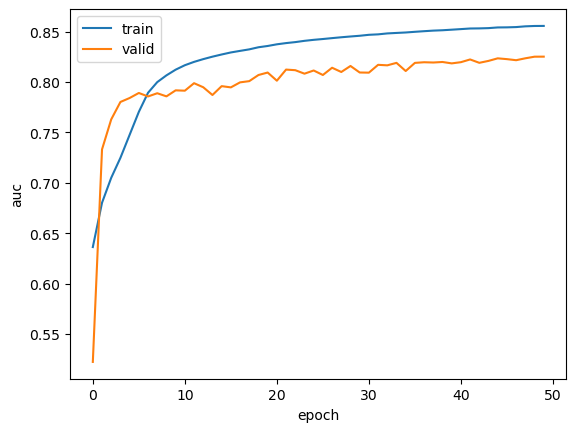

In [85]:
import seaborn as sns

sns.lineplot(data = history_df, x='epoch', y='auc', label='train')
sns.lineplot(data = history_df, x='epoch', y='val_auc', label='valid')

In [90]:
from sklearn.metrics import auc, roc_curve, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt

model_smote = keras.models.load_model('model/model_reduced_features_optuna/oversampled3/tuned_model_logloss_0.44_auc_0.83_checkpoint.h5')
y_pred_smote = model_smote.predict(X_test)

2953/2953 [==============================] - 5s 1ms/step


In [91]:
# using y test here
y_pred_keras_smote = y_pred_smote.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras_smote)
auc_keras_smote = auc(fpr_keras, tpr_keras)
avg_prec_score_smote = average_precision_score(y_test, y_pred_smote)

In [92]:
print("AUC SMOTE: ", auc_keras_smote)
print("Precision Score SMOTE:", avg_prec_score_smote)

AUC SMOTE:  0.8210317240534049
Precision Score SMOTE: 0.26815110382778823


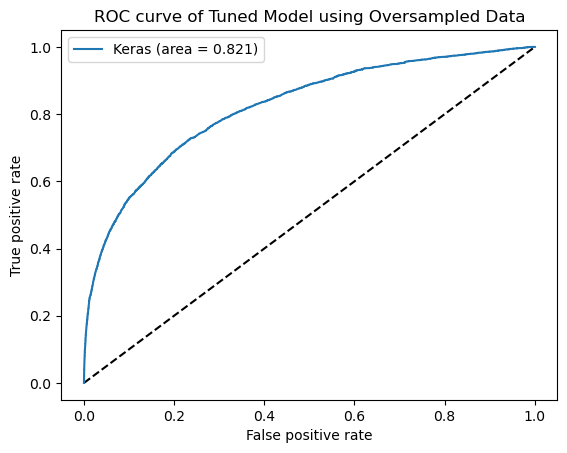

In [93]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras_smote))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of Tuned Model using Oversampled Data')
plt.legend(loc='best')
plt.show()

In [94]:
temp_smote = X_test.copy()
temp_smote['predicted'] = y_pred_smote
temp_smote['true'] = y_test
fraud_cases = temp_smote[temp_smote['true'] == 1]
non_fraud_cases = temp_smote[temp_smote['true']==0]
temp_smote.head()

ProductCD  card3  card4  card6  addr2  R_emaildomain       D12   
305217          4     42      4      2     65             31 -1.416108  \
461940          4     42      4      2     65             31  0.614603   
246802          4     42      4      2     65             31  0.614603   
350081          2     42      4      2     65             30  0.614603   
307850          4     42      4      2     65             31  0.614603   

             D13  M1  M2  M3  M4  M5  M7  M8  M9       V18       V30   
305217  0.533902   2   2   2   3   2   2   2   2 -0.540222  1.202141  \
461940  0.533902   1   0   0   2   1   0   0   1 -0.540222 -0.664176   
246802  0.533902   2   2   2   0   0   2   2   2 -0.540222 -0.664176   
350081 -1.833103   2   2   2   3   2   2   2   2  1.683197 -0.664176   
307850  0.533902   1   1   1   3   2   2   2   2 -0.540222  1.202141   

             V40       V60       V70       V80       V81       V91      V173   
305217 -0.504170 -0.519610  1.204801 -0.521953 -0.508172  1.128298 -1.102703  \
461940 -0.504170 -0.519610 -0.664404 -0.521953 -0.508172 -0.694394  0.892322   
246802 -0.504170 -0.519610 -0.664404 -0.521953 -0.508172 -0.694394  0.892322   
350081  2.095003  1.524002 -0.664404  2.457170  2.312554 -0.694394 -1.102703   
307850 -0.504170 -0.519610  1.204801 -0.521953 -0.508172  1.128298  0.892322   

            V174      V223  id_12  id_13  id_15  id_16  id_17  id_19  id_20   
305217 -1.135389 -1.072947      2     54      3      2    104    522    394  \
461940  0.854764  0.815741      2     54      3      2    104    522    394   
246802  0.854764  0.815741      2     54      3      2    104    522    394   
350081 -1.135389 -1.072947      1     22      1      1     59    202     83   
307850  0.854764  0.815741      2     54      3      2    104    522    394   

        id_28  id_29  id_30  id_33  id_35  id_36  id_37  DeviceType   
305217      2      2     74    260      2      2      2           1  \
461940      2      2     74    260      2      2      2           1   
246802      2      2     74    260      2      2      2           1   
350081      1      1     68    163      1      0      0           2   
307850      2      2     74    260      2      2      2           1   

        DeviceInfo  R_parent_domain  R_domain_name  R_top_level_domain   
305217        1735               16             24                   8  \
461940        1735               16             24                   8   
246802        1735               16             24                   8   
350081        1727                3             23                   2   
307850        1735               16             24                   8   

        device_name  device_version  os_name  os_version  TransactionAmt   
305217           13             293        7          68       -0.364092  \
461940           13             293        7          68       -0.403605   
246802           13             293        7          68       -0.422421   
350081           12             293        6          46        0.062605   
307850           13             293        7          68       -0.113217   

        predicted  true  
305217   0.130135     0  
461940   0.335500     0  
246802   0.384450     0  
350081   0.389582     0  
307850   0.154611     0

In [95]:
import seaborn as sns

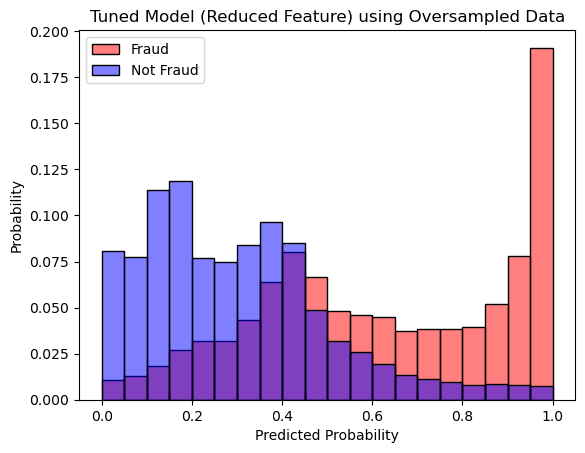

In [96]:

fig, ax = plt.subplots()
sns.histplot(data=fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='red', alpha=0.5, label='Fraud')
sns.histplot(data=non_fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='blue', alpha=0.5, label='Not Fraud')
plt.title("Tuned Model (Reduced Feature) using Oversampled Data")
plt.xlabel("Predicted Probability")
ax.legend()
plt.show()

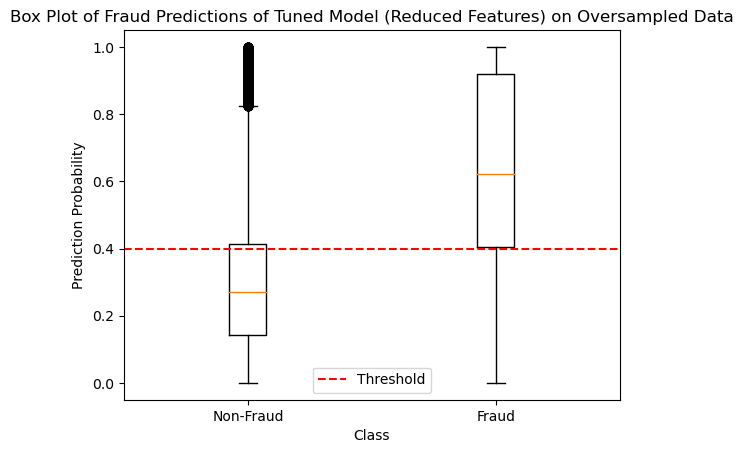

In [97]:
fraud_cases = y_pred_smote[y_test==1]
non_fraud_cases = y_pred_smote[y_test==0]
threshold = 0.4
plt.boxplot([non_fraud_cases.flatten(), fraud_cases.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot of Fraud Predictions of Tuned Model (Reduced Features) on Oversampled Data')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

Threshold: 0.3


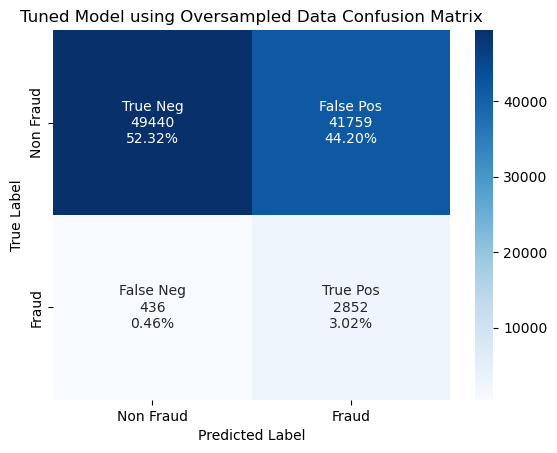

Metrics when threshold is 0.3: 
False Positive Rate: 0.45788879264027016
Recall: 0.8673965936739659
Precision: 0.06393042074824595
Accuracy: 0.5534306306687693
F1: 0.11908390571828223
AUC: 0.8210317240534049
Threshold: 0.31


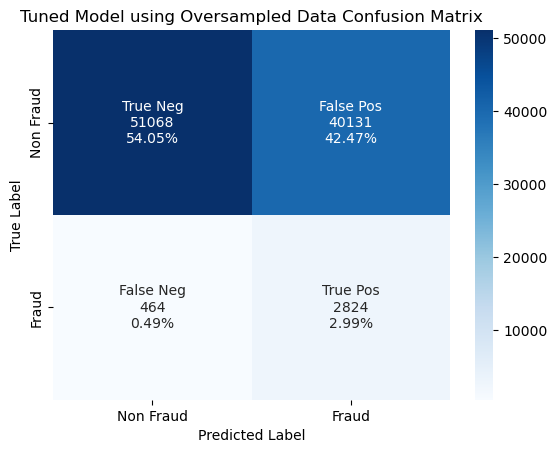

Metrics when threshold is 0.31: 
False Positive Rate: 0.44003771971183897
Recall: 0.8588807785888077
Precision: 0.06574321964846933
Accuracy: 0.5703641770825616
F1: 0.12213740458015267
AUC: 0.8210317240534049
Threshold: 0.32


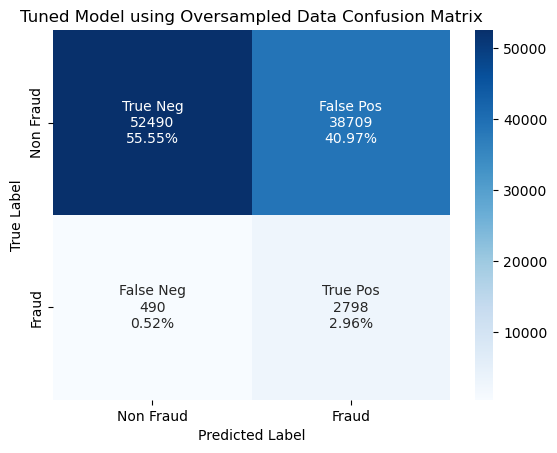

Metrics when threshold is 0.32: 
False Positive Rate: 0.4244454434807399
Recall: 0.8509732360097324
Precision: 0.06741031633218493
Accuracy: 0.5851386963285955
F1: 0.12492465676972876
AUC: 0.8210317240534049
Threshold: 0.33


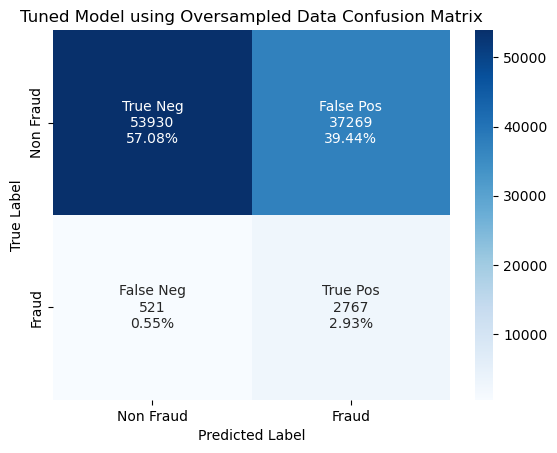

Metrics when threshold is 0.33: 
False Positive Rate: 0.40865579666443713
Recall: 0.8415450121654501
Precision: 0.06911279848136677
Accuracy: 0.6000508006392413
F1: 0.12773520450558581
AUC: 0.8210317240534049
Threshold: 0.34


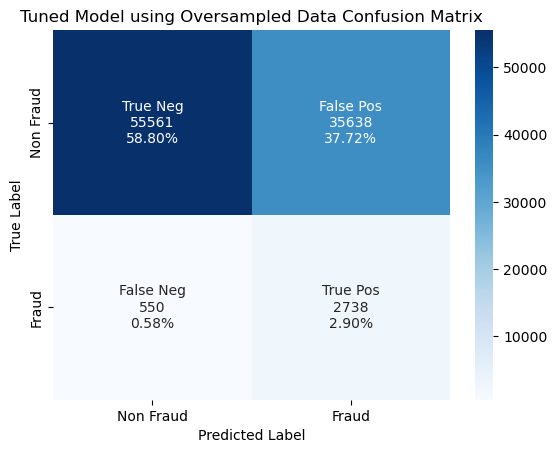

Metrics when threshold is 0.34: 
False Positive Rate: 0.39077182863847193
Recall: 0.8327250608272506
Precision: 0.0713466750052116
Accuracy: 0.617005513986051
F1: 0.13143241167434716
AUC: 0.8210317240534049
Threshold: 0.35


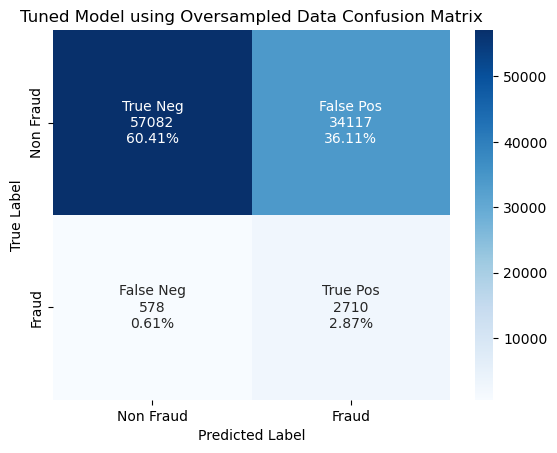

Metrics when threshold is 0.35: 
False Positive Rate: 0.37409401418875204
Recall: 0.8242092457420924
Precision: 0.07358731365574171
Accuracy: 0.632806629483421
F1: 0.13511155428144087
AUC: 0.8210317240534049
Threshold: 0.36


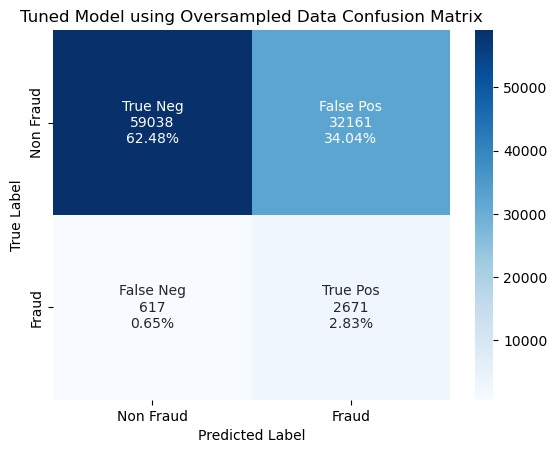

Metrics when threshold is 0.36: 
False Positive Rate: 0.3526464105966074
Recall: 0.8123479318734793
Precision: 0.07668236104731281
Accuracy: 0.653095134780446
F1: 0.14013641133263377
AUC: 0.8210317240534049
Threshold: 0.37


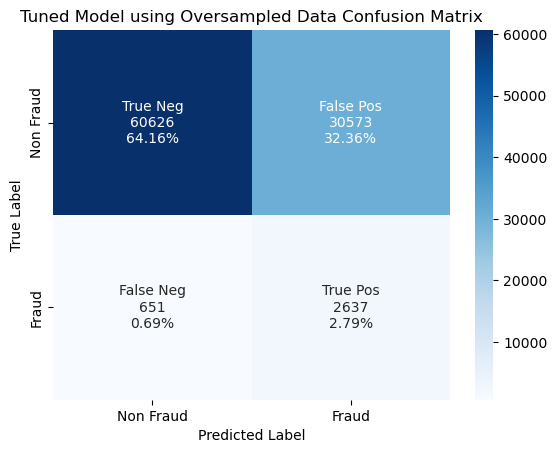

Metrics when threshold is 0.37: 
False Positive Rate: 0.335233938968629
Recall: 0.802007299270073
Precision: 0.07940379403794037
Accuracy: 0.6695418417348419
F1: 0.14450106855170144
AUC: 0.8210317240534049
Threshold: 0.38


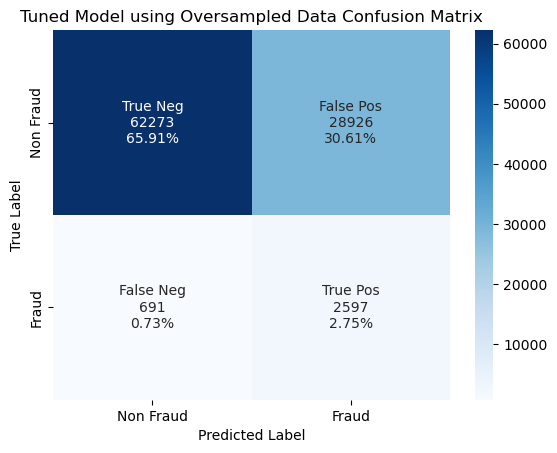

Metrics when threshold is 0.38: 
False Positive Rate: 0.3171745304224827
Recall: 0.7898418491484185
Precision: 0.08238429083526314
Accuracy: 0.6865494724141945
F1: 0.14920571083852804
AUC: 0.8210317240534049
Threshold: 0.39


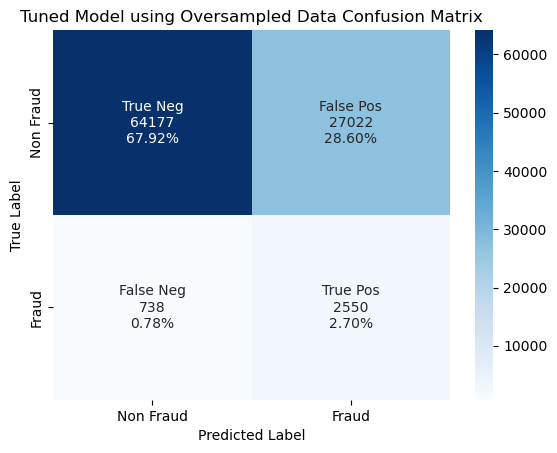

Metrics when threshold is 0.39: 
False Positive Rate: 0.2962971085209268
Recall: 0.7755474452554745
Precision: 0.0862302177735696
Accuracy: 0.7062029697207023
F1: 0.155203895313451
AUC: 0.8210317240534049
Threshold: 0.4


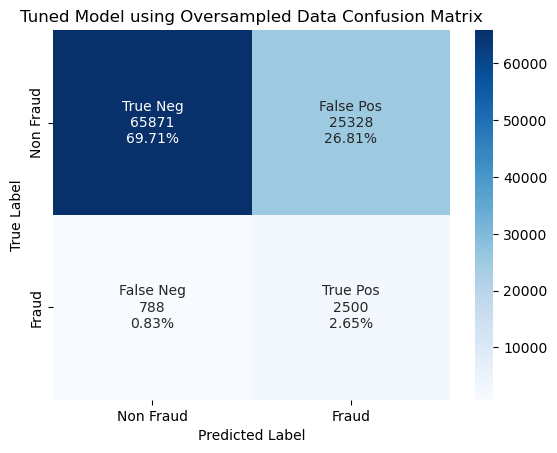

Metrics when threshold is 0.4: 
False Positive Rate: 0.27772234344674834
Recall: 0.7603406326034063
Precision: 0.0898375736668104
Accuracy: 0.723602188660874
F1: 0.16068903458028022
AUC: 0.8210317240534049
Threshold: 0.41


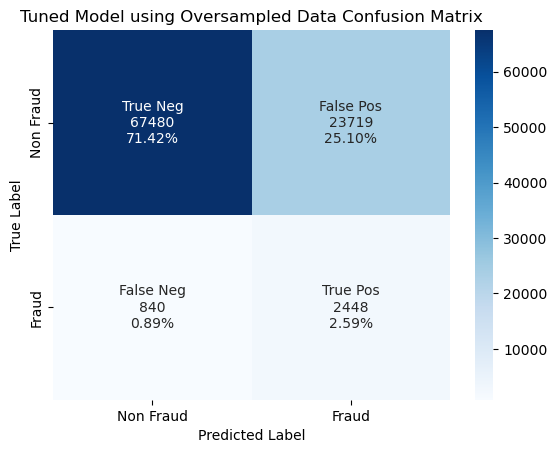

Metrics when threshold is 0.41: 
False Positive Rate: 0.2600796061360322
Recall: 0.7445255474452555
Precision: 0.09355294837008446
Accuracy: 0.7400806460147957
F1: 0.16621965710405703
AUC: 0.8210317240534049
Threshold: 0.42


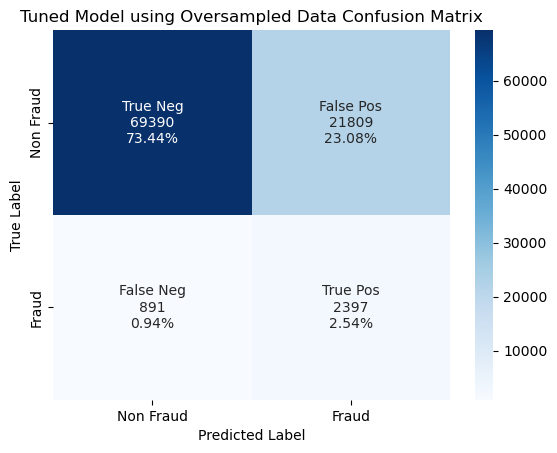

Metrics when threshold is 0.42: 
False Positive Rate: 0.23913639403940834
Recall: 0.7290145985401459
Precision: 0.09902503511526067
Accuracy: 0.7597553102543207
F1: 0.17436531606896052
AUC: 0.8210317240534049
Threshold: 0.43


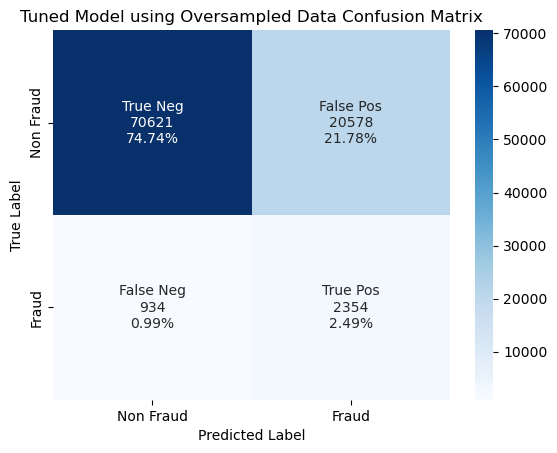

Metrics when threshold is 0.43: 
False Positive Rate: 0.22563843901797168
Recall: 0.7159367396593674
Precision: 0.10265131693703122
Accuracy: 0.7723284684665616
F1: 0.17955758962623952
AUC: 0.8210317240534049
Threshold: 0.44


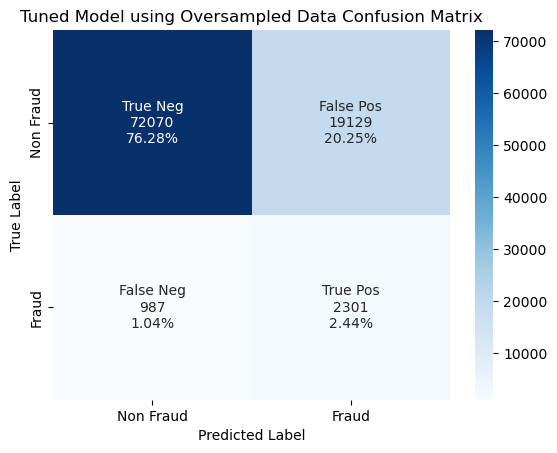

Metrics when threshold is 0.44: 
False Positive Rate: 0.20975010690906698
Recall: 0.6998175182481752
Precision: 0.10737284181054596
Accuracy: 0.7871029877125953
F1: 0.1861801116595194
AUC: 0.8210317240534049
Threshold: 0.45


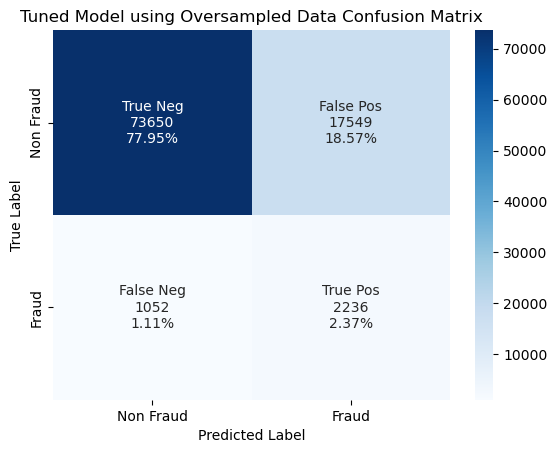

Metrics when threshold is 0.45: 
False Positive Rate: 0.19242535554117918
Recall: 0.6800486618004866
Precision: 0.11301491028556987
Accuracy: 0.803136939473155
F1: 0.1938196160013869
AUC: 0.8210317240534049
Threshold: 0.46


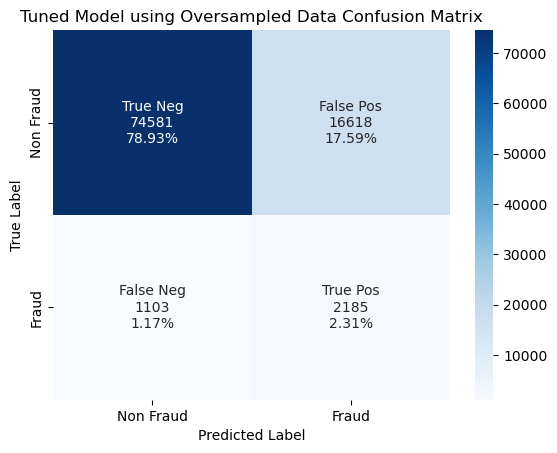

Metrics when threshold is 0.46: 
False Positive Rate: 0.18221691027313897
Recall: 0.6645377128953771
Precision: 0.11620486092644791
Accuracy: 0.8124503900007408
F1: 0.1978181159748314
AUC: 0.8210317240534049
Threshold: 0.47


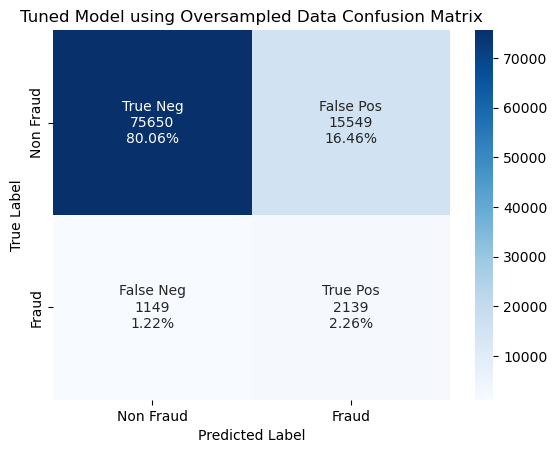

Metrics when threshold is 0.47: 
False Positive Rate: 0.17049529051853637
Recall: 0.6505474452554745
Precision: 0.12092944369063773
Accuracy: 0.8232772762390593
F1: 0.20394736842105265
AUC: 0.8210317240534049
Threshold: 0.48


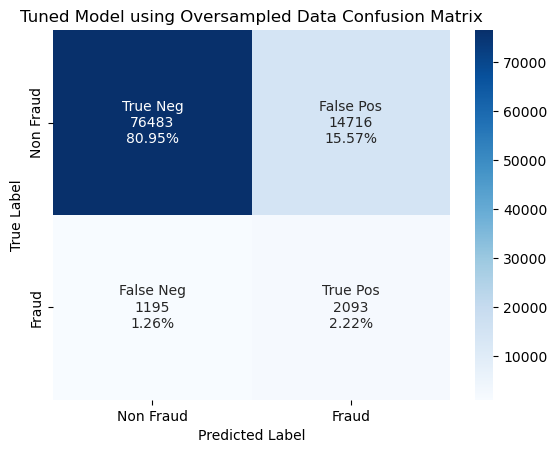

Metrics when threshold is 0.48: 
False Positive Rate: 0.16136141843660567
Recall: 0.6365571776155717
Precision: 0.12451662799690642
Accuracy: 0.8316064643813434
F1: 0.20828979449669102
AUC: 0.8210317240534049
Threshold: 0.49


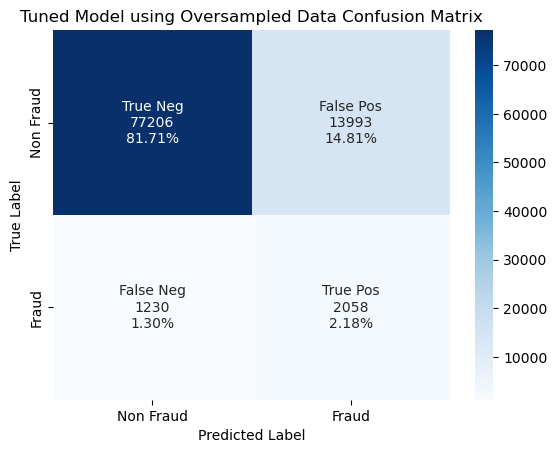

Metrics when threshold is 0.49: 
False Positive Rate: 0.1534336999309203
Recall: 0.6259124087591241
Precision: 0.1282163105102486
Accuracy: 0.8388878893392742
F1: 0.2128341692952066
AUC: 0.8210317240534049
Threshold: 0.5


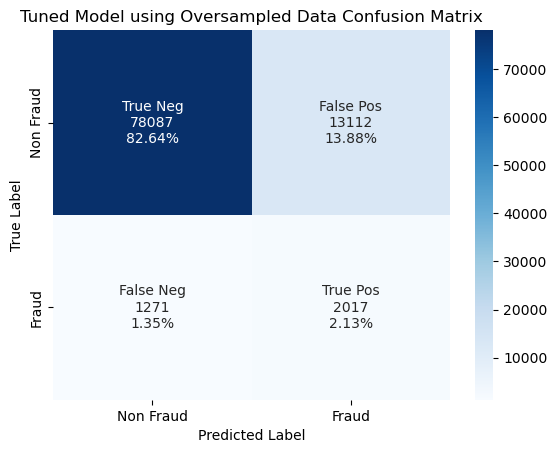

Metrics when threshold is 0.5: 
False Positive Rate: 0.14377350628844615
Recall: 0.6134428223844283
Precision: 0.13332011368894175
Accuracy: 0.8477780012065151
F1: 0.21903675951566484
AUC: 0.8210317240534049
Threshold: 0.51


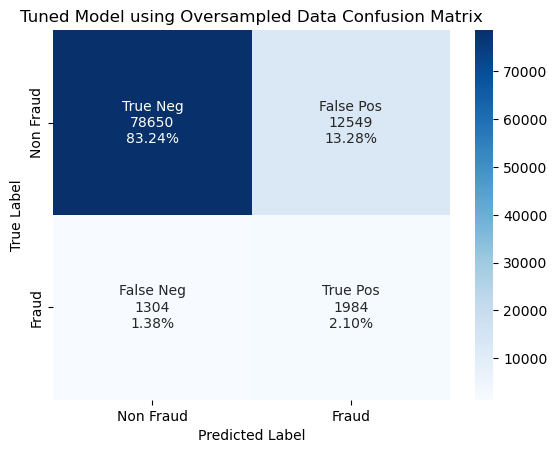

Metrics when threshold is 0.51: 
False Positive Rate: 0.1376001929845722
Recall: 0.6034063260340633
Precision: 0.13651689258927957
Accuracy: 0.8533872384560839
F1: 0.2226586611301274
AUC: 0.8210317240534049
Threshold: 0.52


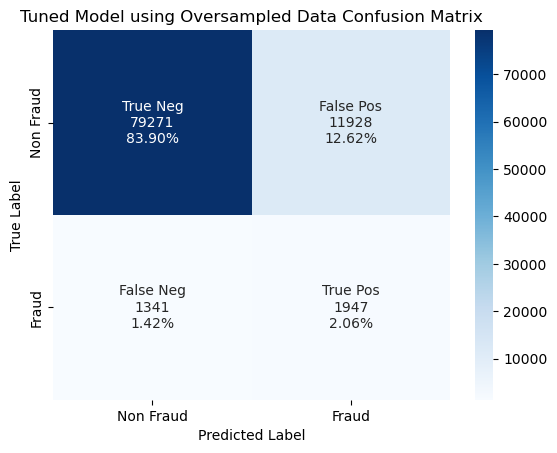

Metrics when threshold is 0.52: 
False Positive Rate: 0.1307909077950416
Recall: 0.5921532846715328
Precision: 0.14032432432432432
Accuracy: 0.8595679828971181
F1: 0.2268834119909107
AUC: 0.8210317240534049
Threshold: 0.53


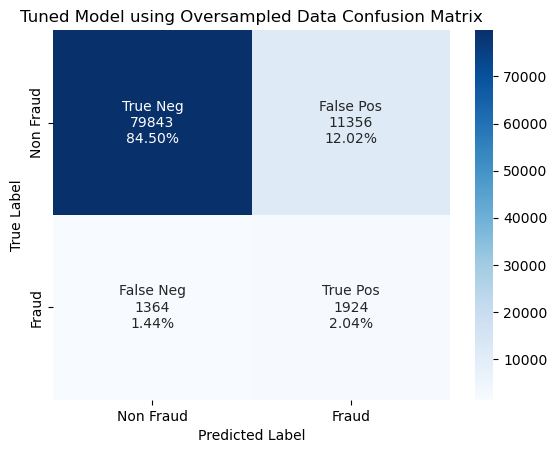

Metrics when threshold is 0.53: 
False Positive Rate: 0.12451890919856577
Recall: 0.5851581508515815
Precision: 0.14487951807228916
Accuracy: 0.8653783060103506
F1: 0.23225494929985516
AUC: 0.8210317240534049
Threshold: 0.54


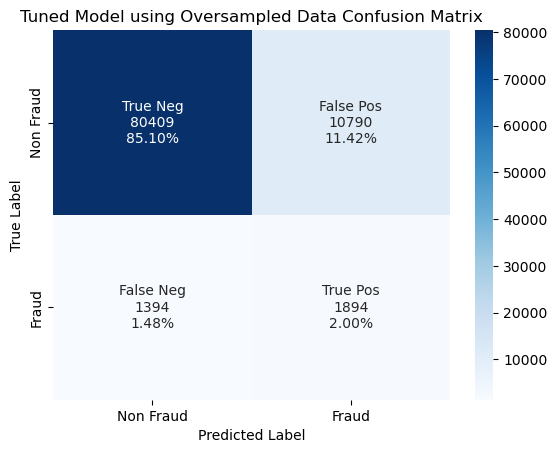

Metrics when threshold is 0.54: 
False Positive Rate: 0.11831270079715786
Recall: 0.5760340632603407
Precision: 0.14932198044780826
Accuracy: 0.871051044058971
F1: 0.23716503881793138
AUC: 0.8210317240534049
Threshold: 0.55


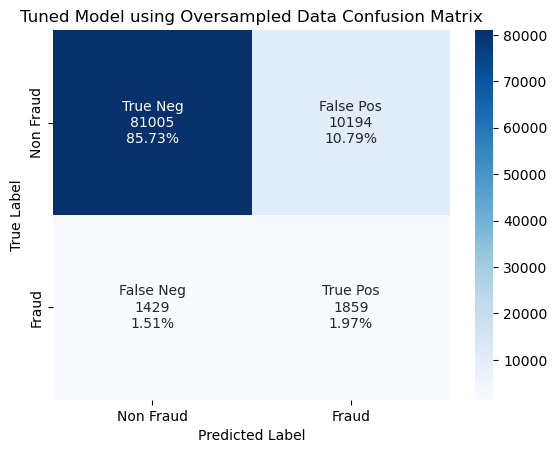

Metrics when threshold is 0.55: 
False Positive Rate: 0.11177754142041031
Recall: 0.565389294403893
Precision: 0.15423546005143948
Accuracy: 0.8769883687703071
F1: 0.242357082328401
AUC: 0.8210317240534049
Threshold: 0.56


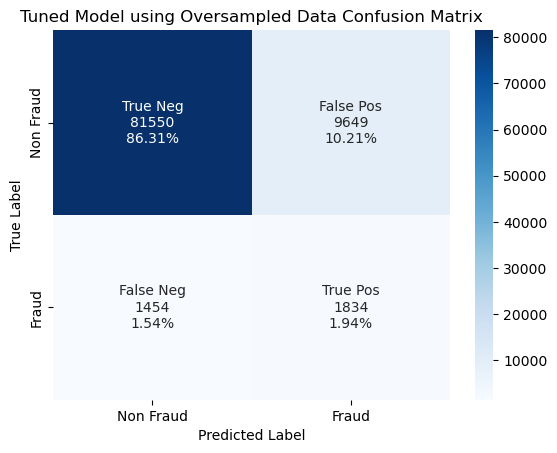

Metrics when threshold is 0.56: 
False Positive Rate: 0.10580159870174015
Recall: 0.5577858880778589
Precision: 0.15971436035879125
Accuracy: 0.8824917713547895
F1: 0.24832441947058423
AUC: 0.8210317240534049
Threshold: 0.57


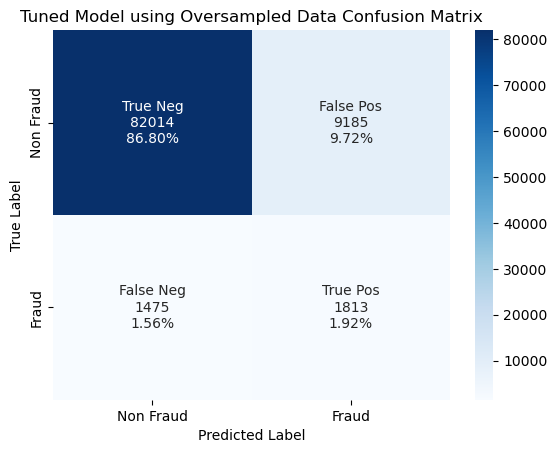

Metrics when threshold is 0.57: 
False Positive Rate: 0.10071382361648702
Recall: 0.5513990267639902
Precision: 0.16484815420985635
Accuracy: 0.8871802470181083
F1: 0.253814923701526
AUC: 0.8210317240534049
Threshold: 0.58


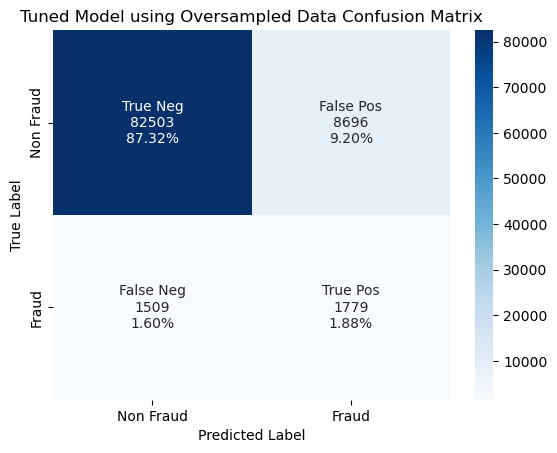

Metrics when threshold is 0.58: 
False Positive Rate: 0.09535192271845086
Recall: 0.541058394160584
Precision: 0.16983293556085918
Accuracy: 0.8919957242795306
F1: 0.25851921819370777
AUC: 0.8210317240534049
Threshold: 0.59


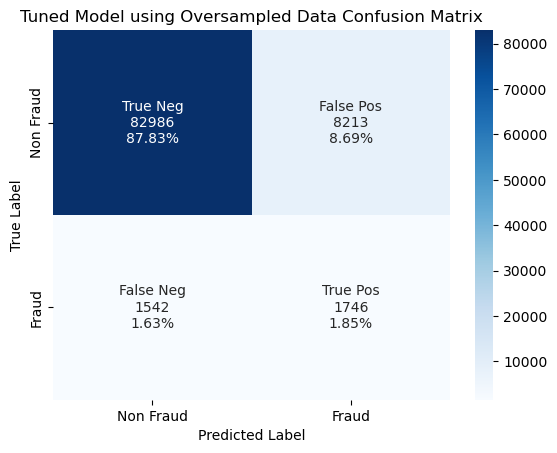

Metrics when threshold is 0.59: 
False Positive Rate: 0.09005581201548263
Recall: 0.531021897810219
Precision: 0.17531880710914752
Accuracy: 0.8967582842084096
F1: 0.2636068543821243
AUC: 0.8210317240534049
Threshold: 0.6


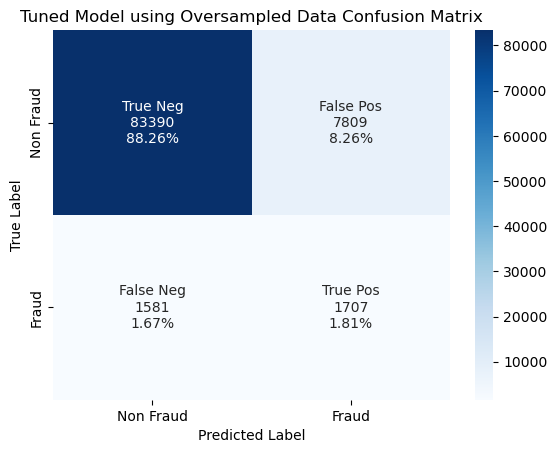

Metrics when threshold is 0.6: 
False Positive Rate: 0.08562593888090878
Recall: 0.5191605839416058
Precision: 0.17938209331651955
Accuracy: 0.900621249484056
F1: 0.2666354264292409
AUC: 0.8210317240534049
Threshold: 0.61


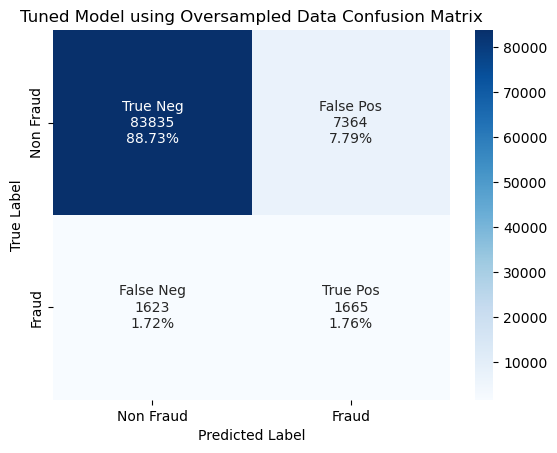

Metrics when threshold is 0.61: 
False Positive Rate: 0.08074649941337077
Recall: 0.5063868613138686
Precision: 0.1844058035219847
Accuracy: 0.90488638648703
F1: 0.2703580417309409
AUC: 0.8210317240534049
Threshold: 0.62


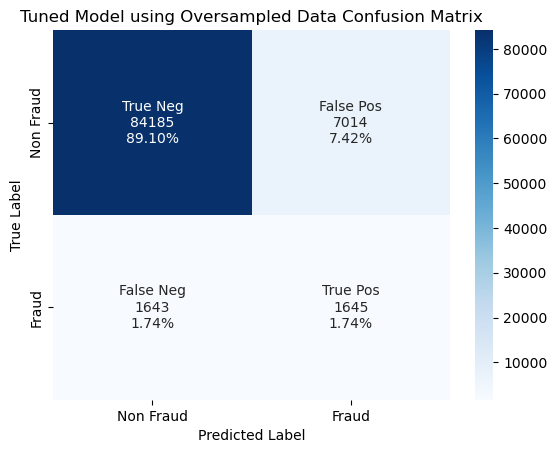

Metrics when threshold is 0.62: 
False Positive Rate: 0.07690873803440827
Recall: 0.5003041362530414
Precision: 0.18997574777687956
Accuracy: 0.9083789304348746
F1: 0.27538294132418184
AUC: 0.8210317240534049
Threshold: 0.63


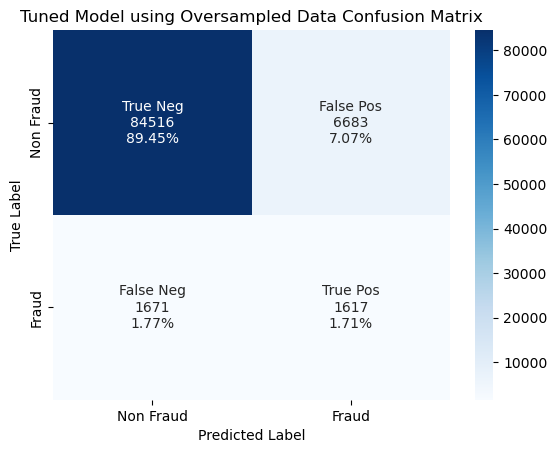

Metrics when threshold is 0.63: 
False Positive Rate: 0.0732793122731609
Recall: 0.49178832116788324
Precision: 0.19481927710843375
Accuracy: 0.9115857207869865
F1: 0.27908180876769073
AUC: 0.8210317240534049
Threshold: 0.64


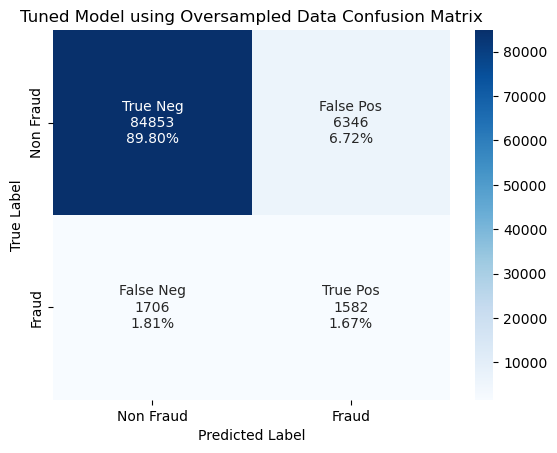

Metrics when threshold is 0.64: 
False Positive Rate: 0.06958409631684558
Recall: 0.4811435523114355
Precision: 0.19954591321897075
Accuracy: 0.9147819276725899
F1: 0.28209700427960055
AUC: 0.8210317240534049
Threshold: 0.65


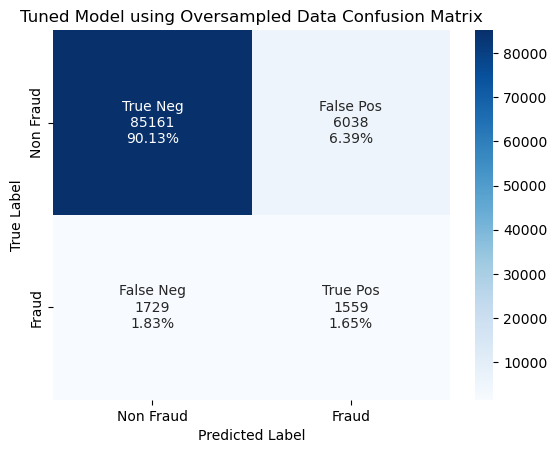

Metrics when threshold is 0.65: 
False Positive Rate: 0.06620686630335859
Recall: 0.4741484184914842
Precision: 0.20521258391470318
Accuracy: 0.9177982156275466
F1: 0.2864492420762517
AUC: 0.8210317240534049
Threshold: 0.66


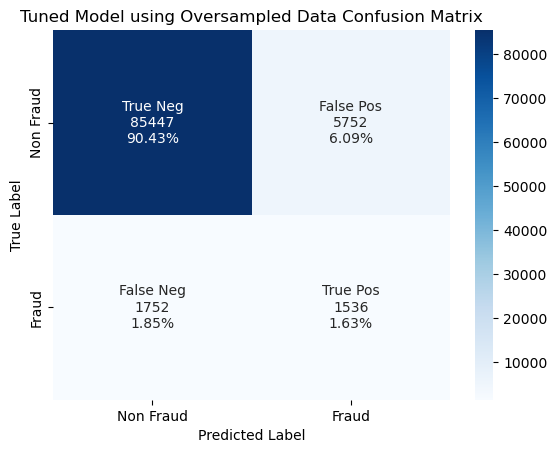

Metrics when threshold is 0.66: 
False Positive Rate: 0.06307086700512067
Recall: 0.46715328467153283
Precision: 0.21075740944017562
Accuracy: 0.9205816673193138
F1: 0.29046898638426627
AUC: 0.8210317240534049
Threshold: 0.67


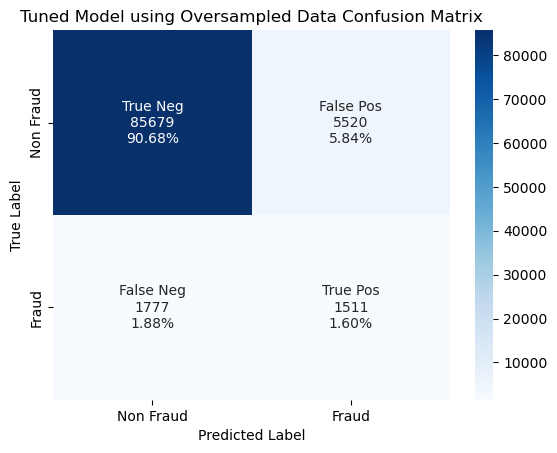

Metrics when threshold is 0.67: 
False Positive Rate: 0.06052697946249411
Recall: 0.45954987834549876
Precision: 0.21490541885933723
Accuracy: 0.9227724448865982
F1: 0.29285783506153695
AUC: 0.8210317240534049
Threshold: 0.68


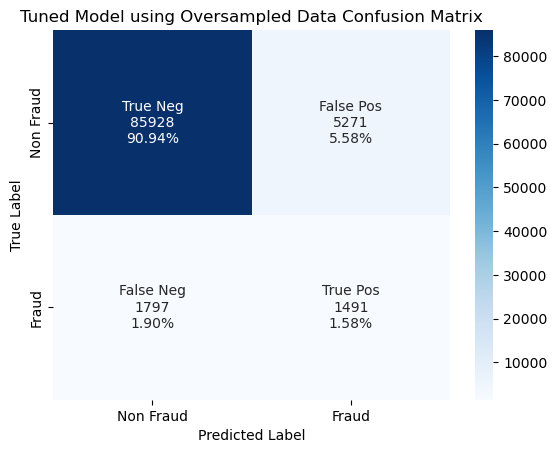

Metrics when threshold is 0.68: 
False Positive Rate: 0.05779668636717508
Recall: 0.4534671532846715
Precision: 0.2204968944099379
Accuracy: 0.9251960587170722
F1: 0.2967164179104478
AUC: 0.8210317240534049
Threshold: 0.69


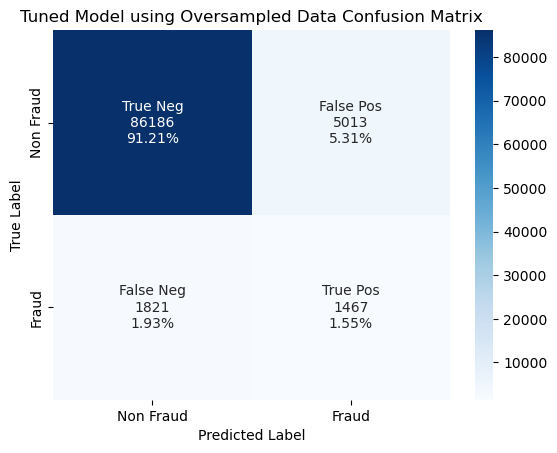

Metrics when threshold is 0.69: 
False Positive Rate: 0.05496770797925416
Recall: 0.44616788321167883
Precision: 0.2263888888888889
Accuracy: 0.9276725898800893
F1: 0.30036855036855037
AUC: 0.8210317240534049
Threshold: 0.7


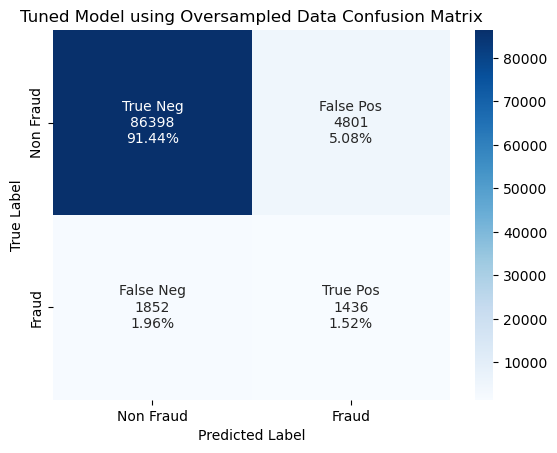

Metrics when threshold is 0.7: 
False Positive Rate: 0.052643121086854025
Recall: 0.4367396593673966
Precision: 0.23023889690556357
Accuracy: 0.9295881973181496
F1: 0.3015223097112861
AUC: 0.8210317240534049


In [105]:
import pandas as pd
from sklearn.metrics import average_precision_score
threshold = np.round(np.arange(0.3, 0.71, 0.01), 2)
results = []

for thresh in threshold:
    print(f"Threshold: {thresh}")
    y_pred_binary = (y_pred_smote > thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_binary)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.title("Tuned Model using Oversampled Data Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    ax.yaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = (2 * recall * precision) / (recall + precision)
    avg_prec_score_smote = average_precision_score(y_test, y_pred_smote)
    print(f"Metrics when threshold is {thresh}: ")

    print(f"False Positive Rate: {fpr}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1}")
    print(f"AUC: {auc_keras_smote}")
    print("="*80)
    
    result = {
        'Threshold': thresh,
        'False Positive Rate': fpr,
        'Recall': recall,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1,
        'AUC': auc_keras_smote,
        'Avg Precision Score': avg_prec_score_smote
    }
    results.append(result)

df_result_smote = pd.DataFrame(results)

In [106]:
df_result_smote

Threshold  False Positive Rate    Recall  Precision  Accuracy        F1   
0        0.30             0.457889  0.867397   0.063930  0.553431  0.119084  \
1        0.31             0.440038  0.858881   0.065743  0.570364  0.122137   
2        0.32             0.424445  0.850973   0.067410  0.585139  0.124925   
3        0.33             0.408656  0.841545   0.069113  0.600051  0.127735   
4        0.34             0.390772  0.832725   0.071347  0.617006  0.131432   
5        0.35             0.374094  0.824209   0.073587  0.632807  0.135112   
6        0.36             0.352646  0.812348   0.076682  0.653095  0.140136   
7        0.37             0.335234  0.802007   0.079404  0.669542  0.144501   
8        0.38             0.317175  0.789842   0.082384  0.686549  0.149206   
9        0.39             0.296297  0.775547   0.086230  0.706203  0.155204   
10       0.40             0.277722  0.760341   0.089838  0.723602  0.160689   
11       0.41             0.260080  0.744526   0.093553  0.740081  0.166220   
12       0.42             0.239136  0.729015   0.099025  0.759755  0.174365   
13       0.43             0.225638  0.715937   0.102651  0.772328  0.179558   
14       0.44             0.209750  0.699818   0.107373  0.787103  0.186180   
15       0.45             0.192425  0.680049   0.113015  0.803137  0.193820   
16       0.46             0.182217  0.664538   0.116205  0.812450  0.197818   
17       0.47             0.170495  0.650547   0.120929  0.823277  0.203947   
18       0.48             0.161361  0.636557   0.124517  0.831606  0.208290   
19       0.49             0.153434  0.625912   0.128216  0.838888  0.212834   
20       0.50             0.143774  0.613443   0.133320  0.847778  0.219037   
21       0.51             0.137600  0.603406   0.136517  0.853387  0.222659   
22       0.52             0.130791  0.592153   0.140324  0.859568  0.226883   
23       0.53             0.124519  0.585158   0.144880  0.865378  0.232255   
24       0.54             0.118313  0.576034   0.149322  0.871051  0.237165   
25       0.55             0.111778  0.565389   0.154235  0.876988  0.242357   
26       0.56             0.105802  0.557786   0.159714  0.882492  0.248324   
27       0.57             0.100714  0.551399   0.164848  0.887180  0.253815   
28       0.58             0.095352  0.541058   0.169833  0.891996  0.258519   
29       0.59             0.090056  0.531022   0.175319  0.896758  0.263607   
30       0.60             0.085626  0.519161   0.179382  0.900621  0.266635   
31       0.61             0.080746  0.506387   0.184406  0.904886  0.270358   
32       0.62             0.076909  0.500304   0.189976  0.908379  0.275383   
33       0.63             0.073279  0.491788   0.194819  0.911586  0.279082   
34       0.64             0.069584  0.481144   0.199546  0.914782  0.282097   
35       0.65             0.066207  0.474148   0.205213  0.917798  0.286449   
36       0.66             0.063071  0.467153   0.210757  0.920582  0.290469   
37       0.67             0.060527  0.459550   0.214905  0.922772  0.292858   
38       0.68             0.057797  0.453467   0.220497  0.925196  0.296716   
39       0.69             0.054968  0.446168   0.226389  0.927673  0.300369   
40       0.70             0.052643  0.436740   0.230239  0.929588  0.301522   

         AUC  Avg Precision Score  
0   0.821032             0.268151  
1   0.821032             0.268151  
2   0.821032             0.268151  
3   0.821032             0.268151  
4   0.821032             0.268151  
5   0.821032             0.268151  
6   0.821032             0.268151  
7   0.821032             0.268151  
8   0.821032             0.268151  
9   0.821032             0.268151  
10  0.821032             0.268151  
11  0.821032             0.268151  
12  0.821032             0.268151  
13  0.821032             0.268151  
14  0.821032             0.268151  
15  0.821032             0.268151  
16  0.821032             0.268151  
17  0.821032             0.268151  
1

# Undersampled

In [8]:
from imblearn.under_sampling import RandomUnderSampler

In [9]:
rus = RandomUnderSampler(random_state=0, sampling_strategy=0.9)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f"X_train_rus shape: {X_train_rus.shape}")
print(f"y_train_rus shape: {y_train_rus.shape}")

X_train_rus shape: (28122, 51)
y_train_rus shape: (28122,)


In [10]:
import optuna
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_auc_score, confusion_matrix

In [11]:

def objective(trial):
    # Define the hyperparameters to optimize
    num_layers = trial.suggest_int('num_layers', 2, 4)
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [3e-7, 1e-6, 1e-5, 1e-4, 1e-3])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    layer_units = []

    # Define the number of neurons in each layer
    for i in range(num_layers):
        layer_units.append(trial.suggest_int(f'layer_{i}_units', 64, 512, step=32))

    # Define the model architecture
    model = Sequential()
    for i, units in enumerate(layer_units):
        if i == 0:
            model.add(Dense(units, activation='relu', input_shape=[X_train_rus.shape[1]]))
        else:
            model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Define optimizer with the suggested learning rate
    if optimizer == 'adam':
        opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)

    auc_metric = tf.keras.metrics.AUC(name='auc')


    # Compile the model with the specified optimizer
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=[auc_metric])

    # Define callbacks
    early_stop = EarlyStopping(patience=5, monitor='val_auc', restore_best_weights=True)

    # Train the model
    model.fit(X_train_rus, y_train_rus, batch_size=batch_size, validation_data=(X_val, y_val), epochs=50, verbose=0, callbacks=[early_stop])

    # Predict probabilities for validation set
    y_pred_proba = model.predict(X_test)
    # y_pred_binary = (y_pred_proba > 0.4).astype(int)
    # cm = confusion_matrix(y_test, y_pred_binary)

    # Calculate the AUC
    auc_score = roc_auc_score(y_test, y_pred_proba)

    return auc_score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)


print(f"Best params: {study.best_params}")
print(f"Best value for AUC: {study.best_value}")

[I 2023-07-01 09:48:32,587] A new study created in memory with name: no-name-be63f0de-d237-4926-94b9-f7e6a5ce62a4


Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-07-01 09:48:35.433091: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 09:51:25,424] Trial 0 finished with value: 0.6613181852609741 and parameters: {'num_layers': 4, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 320, 'layer_1_units': 384, 'layer_2_units': 320, 'layer_3_units': 96}. Best is trial 0 with value: 0.6613181852609741.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 09:52:12,296] Trial 1 finished with value: 0.44799650247477585 and parameters: {'num_layers': 4, 'dropout_rate': 0.5, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 160, 'layer_1_units': 448, 'layer_2_units': 128, 'layer_3_units': 448}. Best is trial 0 with value: 0.6613181852609741.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 09:52:58,436] Trial 2 finished with value: 0.7100998891117734 and parameters: {'num_layers': 4, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 64, 'layer_1_units': 64, 'layer_2_units': 512, 'layer_3_units': 480}. Best is trial 2 with value: 0.7100998891117734.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 09:54:13,037] Trial 3 finished with value: 0.5701969692676818 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 1e-05, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 384, 'layer_1_units': 352}. Best is trial 2 with value: 0.7100998891117734.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 09:55:11,436] Trial 4 finished with value: 0.7088122948241657 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 1e-05, 'optimizer': 'sgd', 'batch_size': 512, 'layer_0_units': 512, 'layer_1_units': 480}. Best is trial 2 with value: 0.7100998891117734.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 09:57:53,706] Trial 5 finished with value: 0.7788142545902867 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 256, 'layer_1_units': 352}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:02:16,575] Trial 6 finished with value: 0.3640700485895006 and parameters: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 1e-05, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 384, 'layer_1_units': 64, 'layer_2_units': 352}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 10:03:35,140] Trial 7 finished with value: 0.5774256285998356 and parameters: {'num_layers': 4, 'dropout_rate': 0.3, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 320, 'layer_1_units': 384, 'layer_2_units': 320, 'layer_3_units': 448}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:04:56,559] Trial 8 finished with value: 0.6815773884248582 and parameters: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 64, 'layer_1_units': 416, 'layer_2_units': 96}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:06:36,044] Trial 9 finished with value: 0.6472090597367234 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 256, 'layer_1_units': 160, 'layer_2_units': 448}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:07:35,230] Trial 10 finished with value: 0.4894794114706885 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 192, 'layer_1_units': 256}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 10:08:25,905] Trial 11 finished with value: 0.6030004430833575 and parameters: {'num_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 1e-06, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 64, 'layer_1_units': 256, 'layer_2_units': 512}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:09:12,889] Trial 12 finished with value: 0.7197693803548076 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 128, 'layer_1_units': 64}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:10:32,017] Trial 13 finished with value: 0.7571569914394578 and parameters: {'num_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 256, 'layer_0_units': 192, 'layer_1_units': 160}. Best is trial 5 with value: 0.7788142545902867.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:15:21,571] Trial 14 finished with value: 0.7977937921054915 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 224, 'layer_1_units': 192}. Best is trial 14 with value: 0.7977937921054915.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:16:22,505] Trial 15 finished with value: 0.7182902298172102 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 256, 'layer_1_units': 320}. Best is trial 14 with value: 0.7977937921054915.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:17:54,596] Trial 16 finished with value: 0.6457898583800687 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 384, 'layer_1_units': 192}. Best is trial 14 with value: 0.7977937921054915.


2953/2953 [==============================] - 5s 1ms/step


[I 2023-07-01 10:19:53,578] Trial 17 finished with value: 0.4921607204175762 and parameters: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 1e-06, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 224, 'layer_1_units': 512, 'layer_2_units': 192}. Best is trial 14 with value: 0.7977937921054915.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:24:47,500] Trial 18 finished with value: 0.7979329409692538 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 448, 'layer_1_units': 288}. Best is trial 18 with value: 0.7979329409692538.


2953/2953 [==============================] - 5s 1ms/step


[I 2023-07-01 10:27:06,765] Trial 19 finished with value: 0.7508889980145288 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 512, 'layer_1_units': 224, 'layer_2_units': 224}. Best is trial 18 with value: 0.7979329409692538.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:28:44,522] Trial 20 finished with value: 0.7758334698626616 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 448, 'layer_1_units': 128}. Best is trial 18 with value: 0.7979329409692538.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:32:01,777] Trial 21 finished with value: 0.7884516544379875 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 320, 'layer_1_units': 288}. Best is trial 18 with value: 0.7979329409692538.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:36:59,619] Trial 22 finished with value: 0.7908835172324024 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 448, 'layer_1_units': 288}. Best is trial 18 with value: 0.7979329409692538.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:41:56,609] Trial 23 finished with value: 0.799549112727444 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 448, 'layer_1_units': 288}. Best is trial 23 with value: 0.799549112727444.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:43:22,095] Trial 24 finished with value: 0.7639988098937889 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 448, 'layer_1_units': 224}. Best is trial 23 with value: 0.799549112727444.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:47:41,429] Trial 25 finished with value: 0.6097435995891342 and parameters: {'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 416, 'layer_1_units': 320, 'layer_2_units': 64}. Best is trial 23 with value: 0.799549112727444.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:48:47,226] Trial 26 finished with value: 0.6705195866694977 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 128, 'layer_0_units': 480, 'layer_1_units': 224}. Best is trial 23 with value: 0.799549112727444.


2953/2953 [==============================] - 4s 1ms/step


[I 2023-07-01 10:50:43,074] Trial 27 finished with value: 0.6200954540095722 and parameters: {'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 1e-06, 'optimizer': 'sgd', 'batch_size': 128, 'layer_0_units': 352, 'layer_1_units': 128}. Best is trial 23 with value: 0.799549112727444.


2953/2953 [==============================] - 5s 1ms/step


[I 2023-07-01 11:00:14,826] Trial 28 finished with value: 0.8017549617905967 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 256, 'layer_2_units': 416}. Best is trial 28 with value: 0.8017549617905967.


2953/2953 [==============================] - 5s 1ms/step


[I 2023-07-01 11:01:51,657] Trial 29 finished with value: 0.6919448666826793 and parameters: {'num_layers': 3, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 480, 'layer_1_units': 320, 'layer_2_units': 416}. Best is trial 28 with value: 0.8017549617905967.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 11:11:53,658] Trial 30 finished with value: 0.8041157786444333 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 256, 'layer_2_units': 416, 'layer_3_units': 64}. Best is trial 30 with value: 0.8041157786444333.


2953/2953 [==============================] - 10s 3ms/step


[I 2023-07-01 11:21:59,319] Trial 31 finished with value: 0.8053047843504922 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 256, 'layer_2_units': 416, 'layer_3_units': 96}. Best is trial 31 with value: 0.8053047843504922.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 11:27:02,514] Trial 32 finished with value: 0.7855248594895112 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 256, 'layer_2_units': 416, 'layer_3_units': 64}. Best is trial 31 with value: 0.8053047843504922.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 11:36:53,672] Trial 33 finished with value: 0.8037290478171194 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 256, 'layer_2_units': 384, 'layer_3_units': 192}. Best is trial 31 with value: 0.8053047843504922.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 11:46:14,572] Trial 34 finished with value: 0.8044790153555542 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 128, 'layer_1_units': 192, 'layer_2_units': 384, 'layer_3_units': 192}. Best is trial 31 with value: 0.8053047843504922.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 11:55:36,315] Trial 35 finished with value: 0.8059650824008855 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 192, 'layer_2_units': 384, 'layer_3_units': 192}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 11:59:42,809] Trial 36 finished with value: 0.7263557115507067 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 192, 'layer_2_units': 448, 'layer_3_units': 192}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 12:09:19,757] Trial 37 finished with value: 0.6969330493923491 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 3e-07, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 160, 'layer_1_units': 128, 'layer_2_units': 352, 'layer_3_units': 160}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 12:11:11,367] Trial 38 finished with value: 0.6078884714928764 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 160, 'layer_2_units': 480, 'layer_3_units': 288}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 12:14:08,647] Trial 39 finished with value: 0.6135226306799102 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 1e-06, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 96, 'layer_2_units': 256, 'layer_3_units': 128}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 12:24:12,850] Trial 40 finished with value: 0.8051066250699754 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 160, 'layer_1_units': 192, 'layer_2_units': 384, 'layer_3_units': 256}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 12:34:11,763] Trial 41 finished with value: 0.8041508414035038 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 160, 'layer_1_units': 192, 'layer_2_units': 384, 'layer_3_units': 256}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 5s 2ms/step


[I 2023-07-01 12:43:15,028] Trial 42 finished with value: 0.8033730010725721 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 160, 'layer_1_units': 192, 'layer_2_units': 352, 'layer_3_units': 256}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-01 12:45:39,795] Trial 43 finished with value: 0.7497055998821218 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 192, 'layer_1_units': 160, 'layer_2_units': 384, 'layer_3_units': 224}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-01 12:46:43,635] Trial 44 finished with value: 0.681273685704124 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 64, 'layer_1_units': 224, 'layer_2_units': 288, 'layer_3_units': 352}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-01 12:53:26,538] Trial 45 finished with value: 0.5250636198656404 and parameters: {'num_layers': 4, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 64, 'layer_0_units': 160, 'layer_1_units': 96, 'layer_2_units': 384, 'layer_3_units': 320}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-01 13:04:19,608] Trial 46 finished with value: 0.804678710340898 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 192, 'layer_2_units': 448, 'layer_3_units': 256}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-01 13:08:30,541] Trial 47 finished with value: 0.7528378724699487 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 224, 'layer_2_units': 448, 'layer_3_units': 160}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-01 13:20:07,899] Trial 48 finished with value: 0.8023126977691014 and parameters: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 64, 'layer_1_units': 160, 'layer_2_units': 320, 'layer_3_units': 256}. Best is trial 35 with value: 0.8059650824008855.


2953/2953 [==============================] - 6s 2ms/step


[I 2023-07-01 13:21:13,940] Trial 49 finished with value: 0.7120655529395105 and parameters: {'num_layers': 4, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 512, 'layer_0_units': 96, 'layer_1_units': 96, 'layer_2_units': 480, 'layer_3_units': 192}. Best is trial 35 with value: 0.8059650824008855.


Best params: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 192, 'layer_2_units': 384, 'layer_3_units': 192}
Best value for AUC: 0.8059650824008855


In [12]:
# Create a list of dictionaries containing trial information
trial_data = []
for trial in study.trials:
    trial_dict = {
        'Trial': trial.number,
        'Value (AUC Score)': trial.value,
    }
    trial_dict.update(trial.params)  # Flatten the parameters dictionary
    trial_data.append(trial_dict)

# Create a dataframe from the trial data
df = pd.DataFrame(trial_data)

In [15]:
from csv import writer
df.to_csv("hasil optuna rus optuna.csv")

In [115]:
df

Trial  Value (AUC Score)  num_layers  dropout_rate  learning_rate   
0       0           0.661318           4           0.4   1.000000e-04  \
1       1           0.447997           4           0.5   1.000000e-05   
2       2           0.710100           4           0.5   1.000000e-03   
3       3           0.570197           2           0.3   1.000000e-05   
4       4           0.708812           2           0.2   1.000000e-05   
5       5           0.778814           2           0.3   1.000000e-03   
6       6           0.364070           3           0.3   1.000000e-05   
7       7           0.577426           4           0.3   1.000000e-05   
8       8           0.681577           3           0.3   1.000000e-03   
9       9           0.647209           3           0.2   1.000000e-03   
10     10           0.489479           2           0.4   3.000000e-07   
11     11           0.603000           3           0.5   1.000000e-06   
12     12           0.719769           2           0.5   1.000000e-03   
13     13           0.757157           2           0.5   1.000000e-03   
14     14           0.797794           2           0.3   1.000000e-03   
15     15           0.718290           2           0.3   1.000000e-04   
16     16           0.645790           2           0.3   3.000000e-07   
17     17           0.492161           3           0.3   1.000000e-06   
18     18           0.797933           2           0.3   1.000000e-03   
19     19           0.750889           3           0.2   1.000000e-03   
20     20           0.775833           2           0.4   1.000000e-03   
21     21           0.788452           2           0.3   1.000000e-03   
22     22           0.790884           2           0.3   1.000000e-03   
23     23           0.799549           2           0.3   1.000000e-03   
24     24           0.763999           2           0.3   1.000000e-03   
25     25           0.609744           3           0.3   3.000000e-07   
26     26           0.670520           2           0.3   1.000000e-04   
27     27           0.620095           2           0.3   1.000000e-06   
28     28           0.801755           3           0.2   1.000000e-03   
29     29           0.691945           3           0.2   1.000000e-04   
30     30           0.804116           4           0.2   1.000000e-03   
31     31           0.805305           4           0.2   1.000000e-03   
32     32           0.785525           4           0.2   1.000000e-03   
33     33           0.803729           4           0.2   1.000000e-03   
34     34           0.804479           4           0.2   1.000000e-03   
35     35           0.805965           4           0.2   1.000000e-03   
36     36           0.726356           4           0.2   1.000000e-03   
37     37           0.696933           4           0.2   3.000000e-07   
38     38           0.607888           4           0.2   1.000000e-05   
39     39           0.613523           4           0.2   1.000000e-06   
40     40           0.805107           4           0.2   1.000000e-03   
41     41           0.804151           4           0.2   1.000000e-03   
42     42           0.803373           4           0.2   1.000000e-03   
43     43           0.749706           4           0.2   1.000000e-03   
44     44           0.681274           4           0.2   1.000000e-05   
45     45           0.525064           4           0.4   1.000000e-03   
46     46           0.804679           4           0.2   1.000000e-03   
47     47           0.752838           4           0.2   1.000000e-04   
48     48           0.802313           4           0.2   1.000000e-03   
49     49           0.712066           4           0.5   1.000000e-03   

   optimizer  batch_size  layer_0_units  layer_1_units  layer_2_units   
0       adam          64            320            384          320.0  \
1       adam         512            160            448          128.0   
2       adam         256             64             64       

In [16]:
print(f"Best params: {study.best_params}")
print(f"Best value for AUC: {study.best_value}")

Best params: {'num_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 64, 'layer_0_units': 96, 'layer_1_units': 192, 'layer_2_units': 384, 'layer_3_units': 192}
Best value for AUC: 0.8059650824008855


Epoch 1/100
440/440 [==============================] - ETA: 0s - loss: 3.0540 - auc: 0.5696
Epoch 1: val_auc improved from -inf to 0.69651, saving model to ./model/model_reduced_features_optuna/undersampled/tuned_model_logloss_0.43_auc_0.70_checkpoint.h5
440/440 [==============================] - 39s 80ms/step - loss: 3.0540 - auc: 0.5696 - val_loss: 0.4318 - val_auc: 0.6965
Epoch 2/100
440/440 [==============================] - ETA: 0s - loss: 0.7710 - auc: 0.6084
Epoch 2: val_auc improved from 0.69651 to 0.71747, saving model to ./model/model_reduced_features_optuna/undersampled/tuned_model_logloss_0.63_auc_0.72_checkpoint.h5
440/440 [==============================] - 12s 28ms/step - loss: 0.7710 - auc: 0.6084 - val_loss: 0.6297 - val_auc: 0.7175
Epoch 3/100
440/440 [==============================] - ETA: 0s - loss: 0.6909 - auc: 0.6264
Epoch 3: val_auc did not improve from 0.71747
440/440 [==============================] - 12s 28ms/step - loss: 0.6909 - auc: 0.6264 - val_loss: 0.688

<Axes: xlabel='epoch', ylabel='auc'>

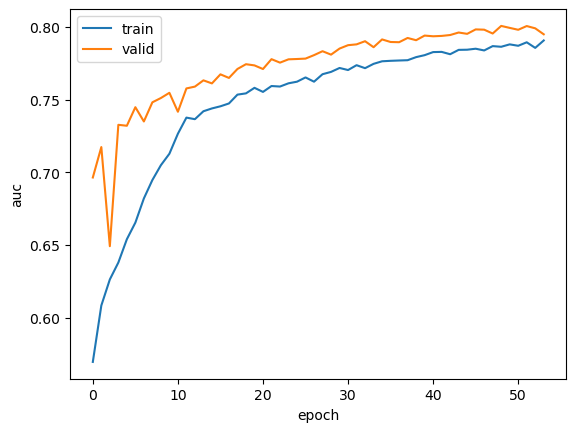

In [30]:
# create model with best params (RUS)

from keras.callbacks import ModelCheckpoint, EarlyStopping

model_reduced_rus = tf.keras.models.Sequential([
    tf.keras.layers.Dense(96, input_shape=[X_train_rus.shape[1]]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(192, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(384, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(192, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optim_func = Adam(learning_rate=0.001)
auc_metric = tf.keras.metrics.AUC(name='auc')
early_stop = EarlyStopping(patience=5, monitor='val_auc', restore_best_weights=True)

checkpoint_callback = ModelCheckpoint(
    filepath="./model/model_reduced_features_optuna/undersampled/tuned_model_logloss_{val_loss:.2f}_auc_{val_auc:.2f}_checkpoint.h5",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)


model_reduced_rus.compile(optimizer=optim_func, loss='binary_crossentropy', metrics=[auc_metric])

# train the model
history = model_reduced_rus.fit(X_train_rus, y_train_rus, epochs=100, batch_size=64, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stop, checkpoint_callback])


history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch

sns.lineplot(data = history_df, x='epoch', y='auc', label='train')
sns.lineplot(data = history_df, x='epoch', y='val_auc', label='valid')

In [42]:
from sklearn.metrics import auc, roc_curve, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt

model_rus = keras.models.load_model('model/model_reduced_features_optuna/undersampled/tuned_model_logloss_0.52_auc_0.80_checkpoint.h5')
y_pred_rus = model_rus.predict(X_test)

2953/2953 [==============================] - 6s 2ms/step


In [43]:
# using x test here
y_pred_keras = y_pred_rus.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras_rus = auc(fpr_keras, tpr_keras)
avg_prec_score_rus = average_precision_score(y_test, y_pred_rus)

In [44]:
print("AUC RUS: ", auc_keras_rus)
print("Precision Score RUS:", avg_prec_score_rus)

AUC RUS:  0.8014763672601845
Precision Score RUS: 0.17605269449105726


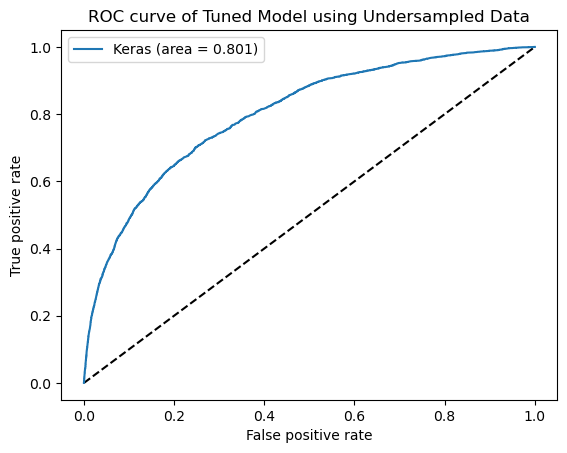

In [45]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras_rus))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of Tuned Model using Undersampled Data')
plt.legend(loc='best')
plt.show()

In [46]:
temp_rus = X_test.copy()
temp_rus['predicted'] = y_pred_rus
temp_rus['true'] = y_test
fraud_cases = temp_rus[temp_rus['true'] == 1]
non_fraud_cases = temp_rus[temp_rus['true']==0]
temp_rus.head()

ProductCD  card3  card4  card6  addr2  R_emaildomain       D12   
305217          4     42      4      2     65             31 -1.416108  \
461940          4     42      4      2     65             31  0.614603   
246802          4     42      4      2     65             31  0.614603   
350081          2     42      4      2     65             30  0.614603   
307850          4     42      4      2     65             31  0.614603   

             D13  M1  M2  M3  M4  M5  M7  M8  M9       V18       V30   
305217  0.533902   2   2   2   3   2   2   2   2 -0.540222  1.202141  \
461940  0.533902   1   0   0   2   1   0   0   1 -0.540222 -0.664176   
246802  0.533902   2   2   2   0   0   2   2   2 -0.540222 -0.664176   
350081 -1.833103   2   2   2   3   2   2   2   2  1.683197 -0.664176   
307850  0.533902   1   1   1   3   2   2   2   2 -0.540222  1.202141   

             V40       V60       V70       V80       V81       V91      V173   
305217 -0.504170 -0.519610  1.204801 -0.521953 -0.508172  1.128298 -1.102703  \
461940 -0.504170 -0.519610 -0.664404 -0.521953 -0.508172 -0.694394  0.892322   
246802 -0.504170 -0.519610 -0.664404 -0.521953 -0.508172 -0.694394  0.892322   
350081  2.095003  1.524002 -0.664404  2.457170  2.312554 -0.694394 -1.102703   
307850 -0.504170 -0.519610  1.204801 -0.521953 -0.508172  1.128298  0.892322   

            V174      V223  id_12  id_13  id_15  id_16  id_17  id_19  id_20   
305217 -1.135389 -1.072947      2     54      3      2    104    522    394  \
461940  0.854764  0.815741      2     54      3      2    104    522    394   
246802  0.854764  0.815741      2     54      3      2    104    522    394   
350081 -1.135389 -1.072947      1     22      1      1     59    202     83   
307850  0.854764  0.815741      2     54      3      2    104    522    394   

        id_28  id_29  id_30  id_33  id_35  id_36  id_37  DeviceType   
305217      2      2     74    260      2      2      2           1  \
461940      2      2     74    260      2      2      2           1   
246802      2      2     74    260      2      2      2           1   
350081      1      1     68    163      1      0      0           2   
307850      2      2     74    260      2      2      2           1   

        DeviceInfo  R_parent_domain  R_domain_name  R_top_level_domain   
305217        1735               16             24                   8  \
461940        1735               16             24                   8   
246802        1735               16             24                   8   
350081        1727                3             23                   2   
307850        1735               16             24                   8   

        device_name  device_version  os_name  os_version  TransactionAmt   
305217           13             293        7          68       -0.364092  \
461940           13             293        7          68       -0.403605   
246802           13             293        7          68       -0.422421   
350081           12             293        6          46        0.062605   
307850           13             293        7          68       -0.113217   

        predicted  true  
305217   0.169155     0  
461940   0.388608     0  
246802   0.427934     0  
350081   0.537172     0  
307850   0.195516     0

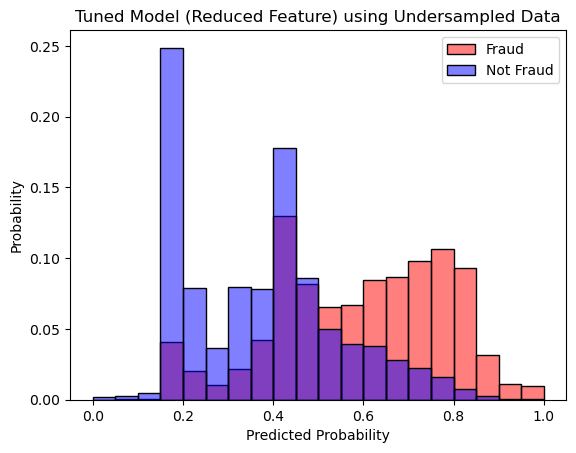

In [47]:

fig, ax = plt.subplots()
sns.histplot(data=fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='red', alpha=0.5, label='Fraud')
sns.histplot(data=non_fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='blue', alpha=0.5, label='Not Fraud')
plt.title("Tuned Model (Reduced Feature) using Undersampled Data")
plt.xlabel("Predicted Probability")
ax.legend()
plt.show()

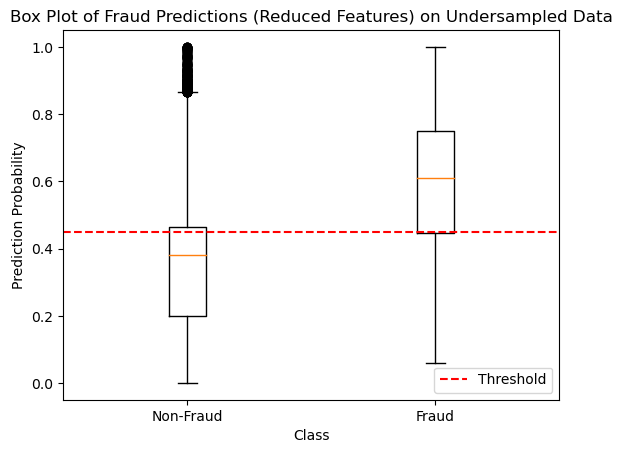

In [48]:
fraud_cases = y_pred_rus[y_test==1]
non_fraud_cases = y_pred_rus[y_test==0]
threshold = 0.45
plt.boxplot([non_fraud_cases.flatten(), fraud_cases.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot of Fraud Predictions (Reduced Features) on Undersampled Data')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

Threshold: 0.3


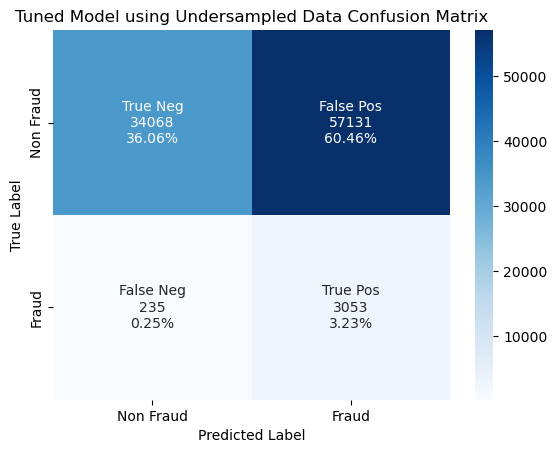

Metrics when threshold is 0.3: 

False Positive Rate: 0.6264432724043026
Recall: 0.9285279805352799
Precision: 0.05072776817758873
Accuracy: 0.3928688602664917
F1: 0.09619989916813713
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.31


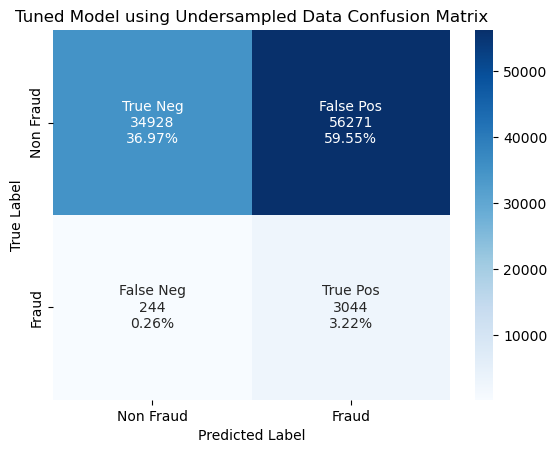

Metrics when threshold is 0.31: 

False Positive Rate: 0.6170133444445662
Recall: 0.9257907542579076
Precision: 0.05131922785130237
Accuracy: 0.4018753902653275
F1: 0.09724773573151446
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.32


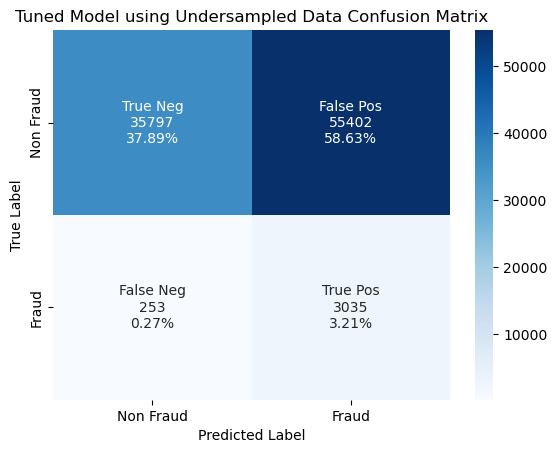

Metrics when threshold is 0.32: 

False Positive Rate: 0.607484731192228
Recall: 0.9230535279805353
Precision: 0.05193627325153584
Accuracy: 0.41097717146274093
F1: 0.0983394086674767
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.33


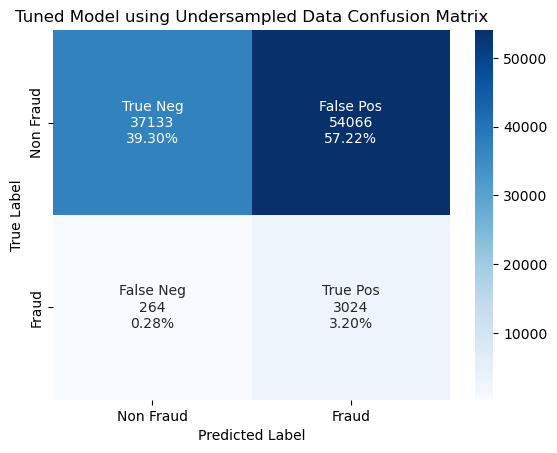

Metrics when threshold is 0.33: 

False Positive Rate: 0.5928354477571026
Recall: 0.9197080291970803
Precision: 0.052968996321597475
Accuracy: 0.42500026458666273
F1: 0.10016893570505812
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.34


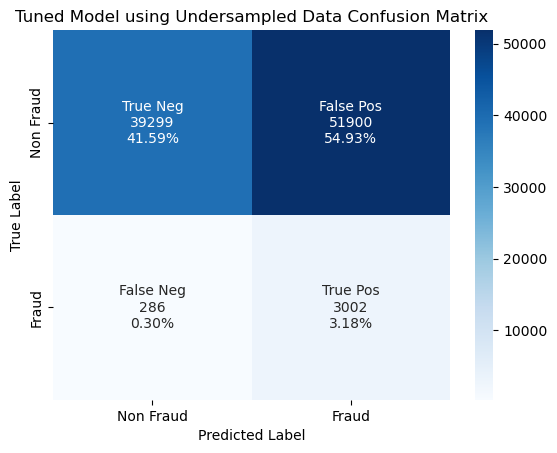

Metrics when threshold is 0.34: 

False Positive Rate: 0.5690851873375804
Recall: 0.9130170316301703
Precision: 0.05467924665768096
Accuracy: 0.4476912167811445
F1: 0.10317924041931605
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.35


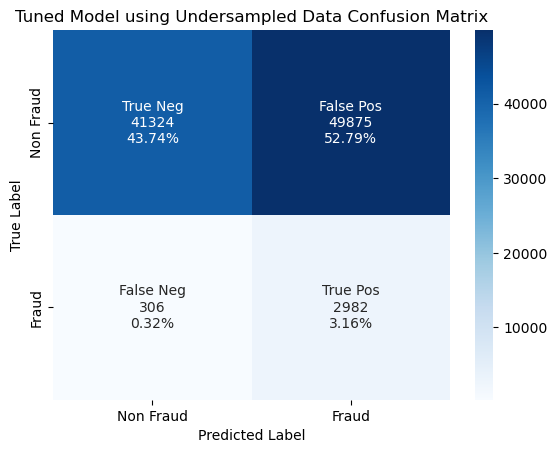

Metrics when threshold is 0.35: 

False Positive Rate: 0.5468809965021546
Recall: 0.906934306569343
Precision: 0.05641636869288836
Accuracy: 0.46891106713092806
F1: 0.10622495324605932
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.36


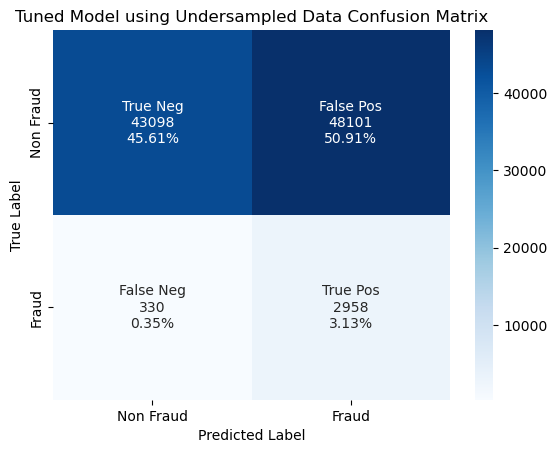

Metrics when threshold is 0.36: 

False Positive Rate: 0.5274290288270704
Recall: 0.8996350364963503
Precision: 0.057932979494310505
Accuracy: 0.4874321335210135
F1: 0.1088560546120301
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.37


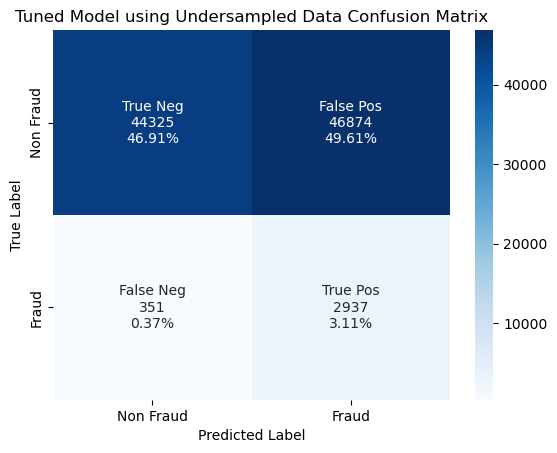

Metrics when threshold is 0.37: 

False Positive Rate: 0.5139749339356792
Recall: 0.8932481751824818
Precision: 0.05896287968521009
Accuracy: 0.5001957941304095
F1: 0.11062355223262209
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.38


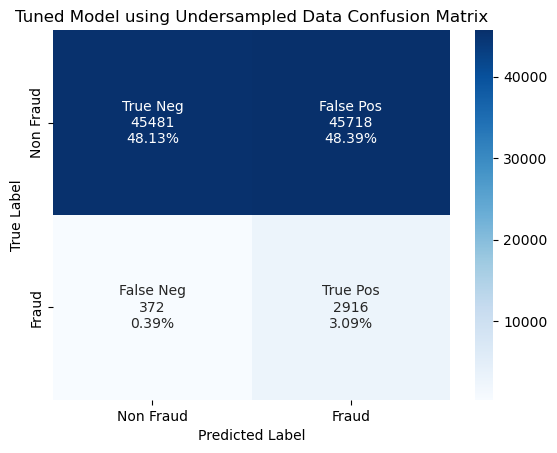

Metrics when threshold is 0.38: 

False Positive Rate: 0.5012993563525916
Recall: 0.8868613138686131
Precision: 0.05995805403627092
Accuracy: 0.5122080286176934
F1: 0.11232232964831862
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.39


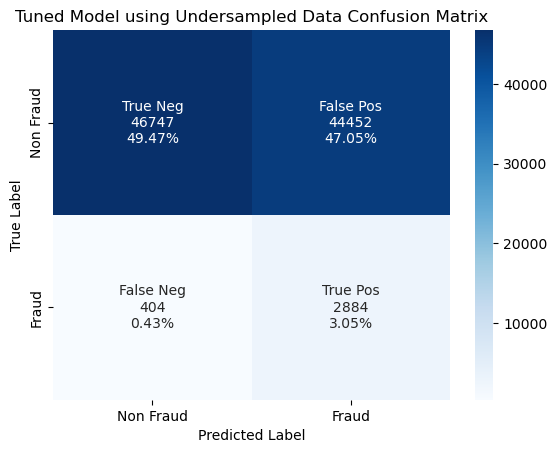

Metrics when threshold is 0.39: 

False Positive Rate: 0.4874176251932587
Recall: 0.8771289537712895
Precision: 0.06092614500591516
Accuracy: 0.5252680262893308
F1: 0.11393805309734513
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.4


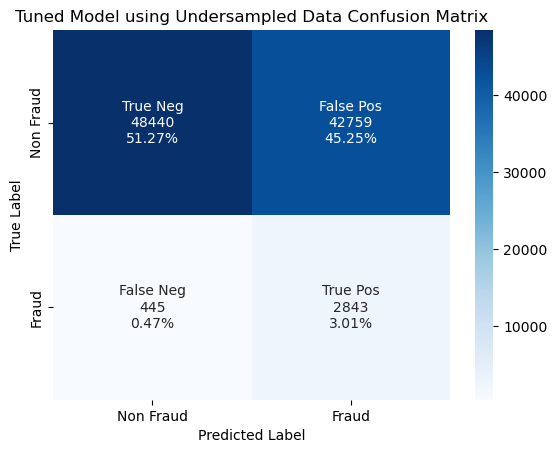

Metrics when threshold is 0.4: 

False Positive Rate: 0.4688538251515916
Recall: 0.8646593673965937
Precision: 0.06234375685276961
Accuracy: 0.5427519129615714
F1: 0.11630190222949478
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.41


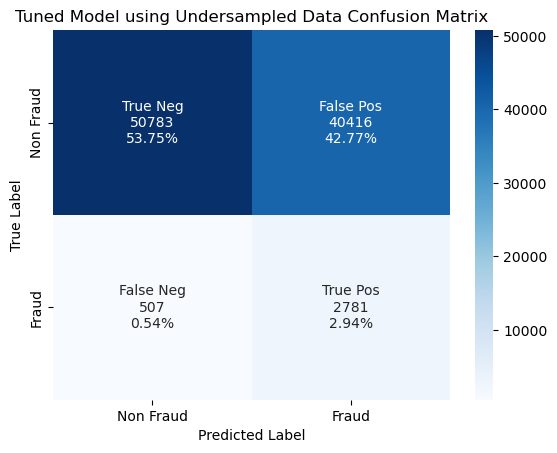

Metrics when threshold is 0.41: 

False Positive Rate: 0.44316275397756555
Recall: 0.8458029197080292
Precision: 0.0643794707965831
Accuracy: 0.5668928000677342
F1: 0.11965150048402712
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.42


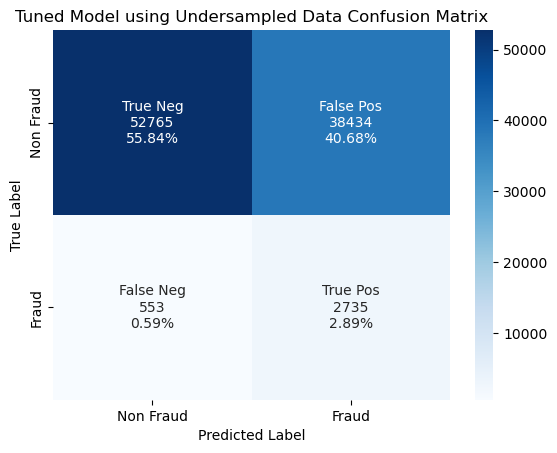

Metrics when threshold is 0.42: 

False Positive Rate: 0.4214300595401265
Recall: 0.8318126520681265
Precision: 0.0664334815030727
Accuracy: 0.587382391228423
F1: 0.12304024113188024
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.43


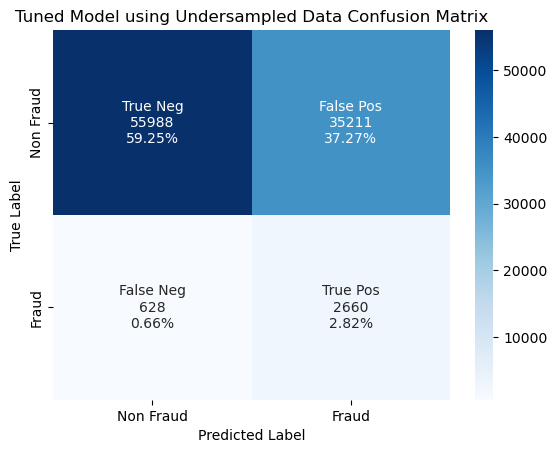

Metrics when threshold is 0.43: 

False Positive Rate: 0.3860897597561377
Recall: 0.8090024330900243
Precision: 0.07023844102347443
Accuracy: 0.6206991437975594
F1: 0.12925484098253115
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.44


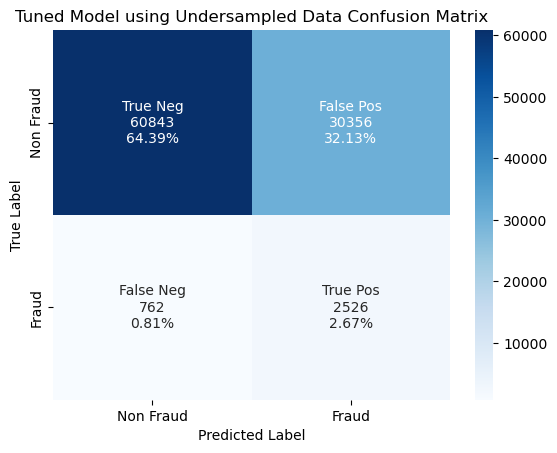

Metrics when threshold is 0.44: 

False Positive Rate: 0.3328545269136723
Recall: 0.7682481751824818
Precision: 0.0768201447600511
Accuracy: 0.6706636891847556
F1: 0.13967376278683993
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.45


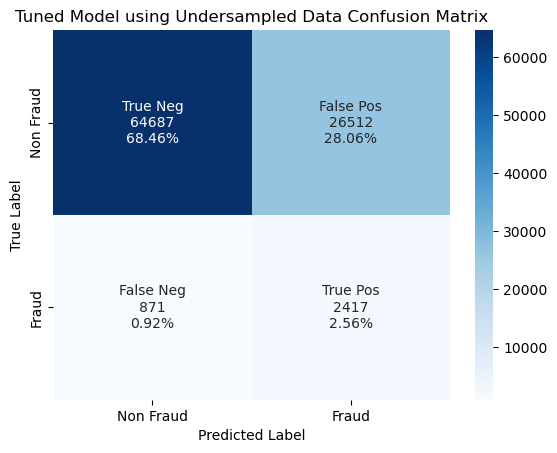

Metrics when threshold is 0.45: 

False Positive Rate: 0.29070494194015284
Recall: 0.7350973236009732
Precision: 0.0835493795153652
Accuracy: 0.7101929365944522
F1: 0.1500450072942856
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.46


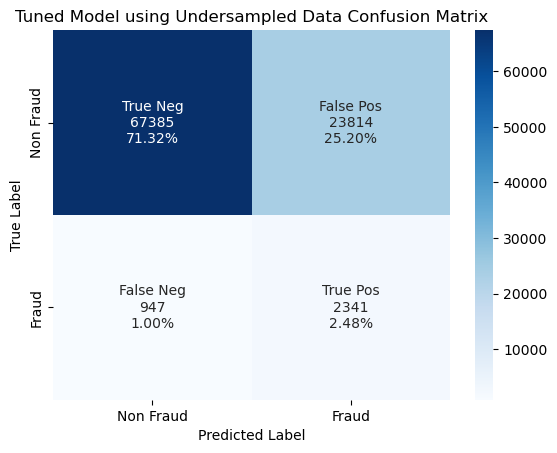

Metrics when threshold is 0.46: 

False Positive Rate: 0.26112128422460773
Recall: 0.7119829683698297
Precision: 0.08950487478493596
Accuracy: 0.7379427857800543
F1: 0.1590191216927623
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.47


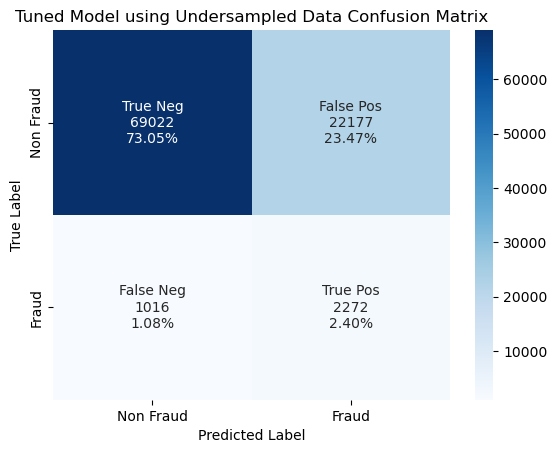

Metrics when threshold is 0.47: 

False Positive Rate: 0.2431715260035746
Recall: 0.6909975669099757
Precision: 0.09292813612008671
Accuracy: 0.754537661265571
F1: 0.16382449435771715
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.48


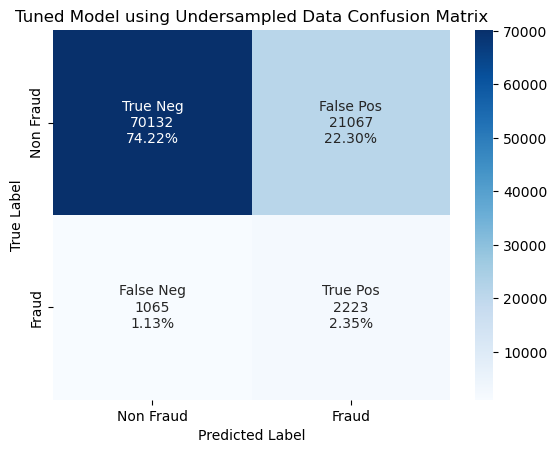

Metrics when threshold is 0.48: 

False Positive Rate: 0.23100033991600785
Recall: 0.676094890510949
Precision: 0.09544869042507514
Accuracy: 0.765766719231217
F1: 0.16728121002332758
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.49


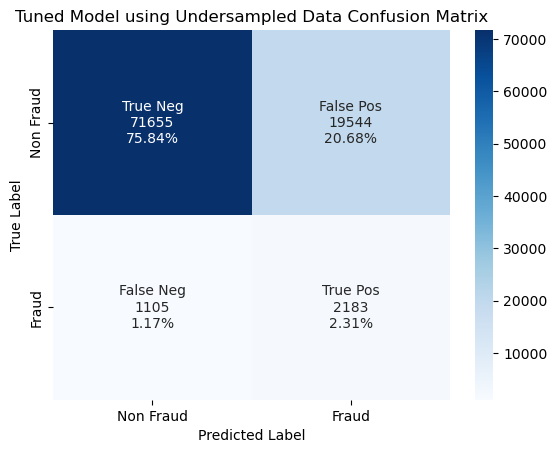

Metrics when threshold is 0.49: 

False Positive Rate: 0.21430059540126536
Recall: 0.6639294403892944
Precision: 0.10047406452800663
Accuracy: 0.7814620000635008
F1: 0.17453527883270037
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.5


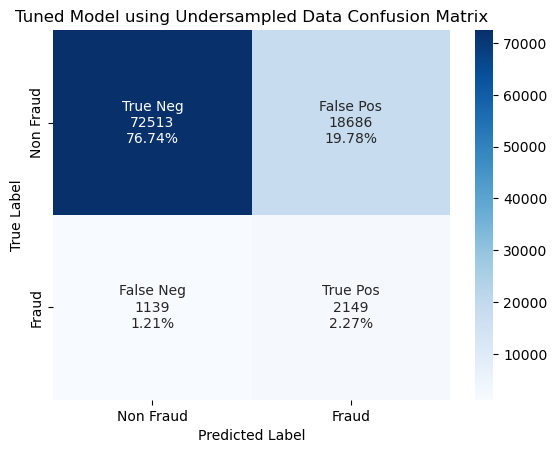

Metrics when threshold is 0.5: 

False Positive Rate: 0.20489259750655162
Recall: 0.6535888077858881
Precision: 0.10314374850012
Accuracy: 0.7901827764666038
F1: 0.17817021100194835
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.51


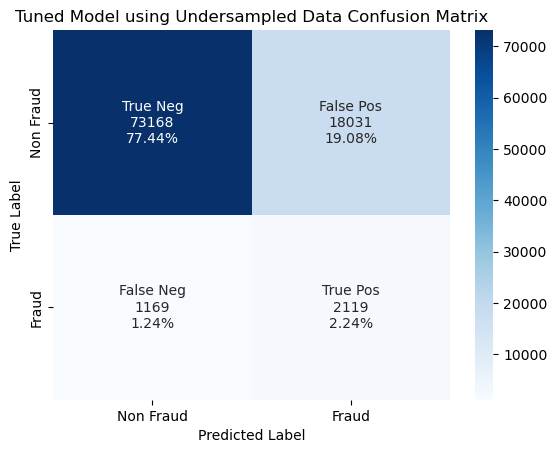

Metrics when threshold is 0.51: 

False Positive Rate: 0.19771050121163608
Recall: 0.6444647201946472
Precision: 0.10516129032258065
Accuracy: 0.7967974430344915
F1: 0.18081747589384758
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.52


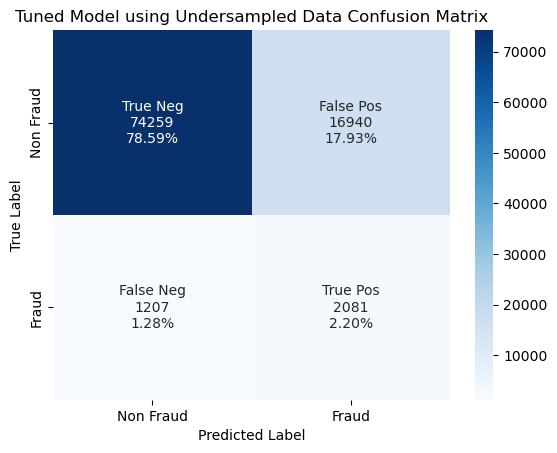

Metrics when threshold is 0.52: 

False Positive Rate: 0.18574765074178445
Recall: 0.6329075425790754
Precision: 0.10940539403816835
Accuracy: 0.8079418332680687
F1: 0.18656147743063337
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.53


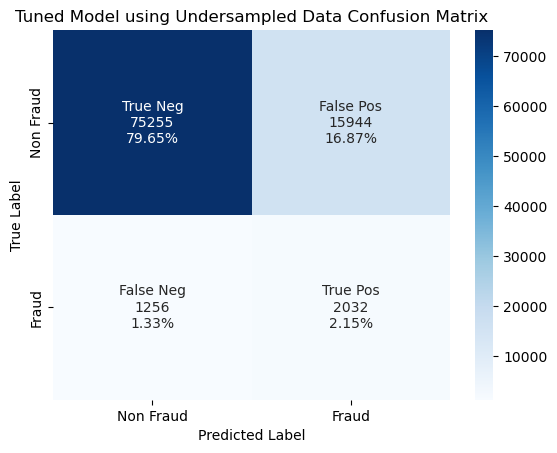

Metrics when threshold is 0.53: 

False Positive Rate: 0.17482647836050835
Recall: 0.6180048661800487
Precision: 0.11303960836671118
Accuracy: 0.817964376051732
F1: 0.19112114371708053
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.54


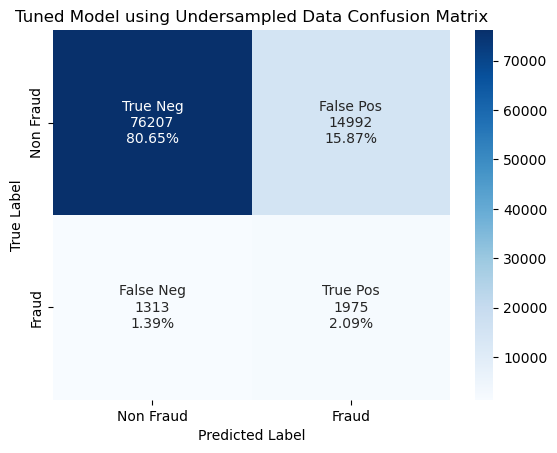

Metrics when threshold is 0.54: 

False Positive Rate: 0.16438776740973038
Recall: 0.600669099756691
Precision: 0.11640242824306006
Accuracy: 0.8274365785769471
F1: 0.19501357689459395
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.55


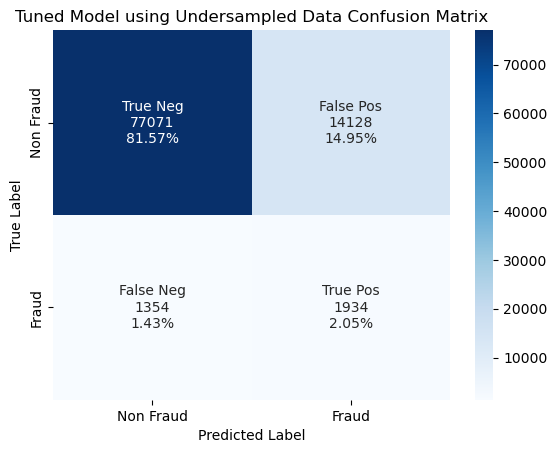

Metrics when threshold is 0.55: 

False Positive Rate: 0.15491397931994869
Recall: 0.5881995133819952
Precision: 0.12040841738264225
Accuracy: 0.8361467715135416
F1: 0.19989664082687333
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.56


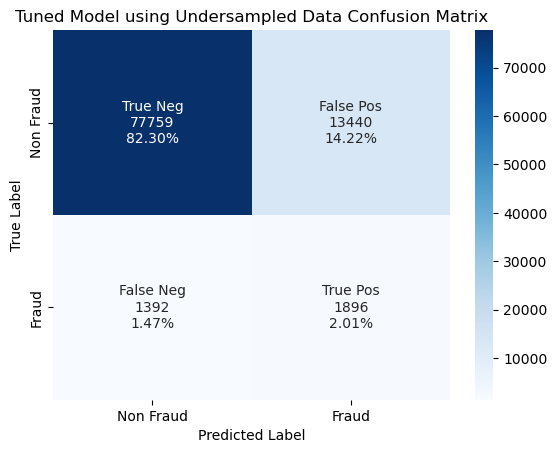

Metrics when threshold is 0.56: 

False Positive Rate: 0.14737003695215956
Recall: 0.5766423357664233
Precision: 0.12363067292644757
Accuracy: 0.8430260247441447
F1: 0.2036082474226804
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.57


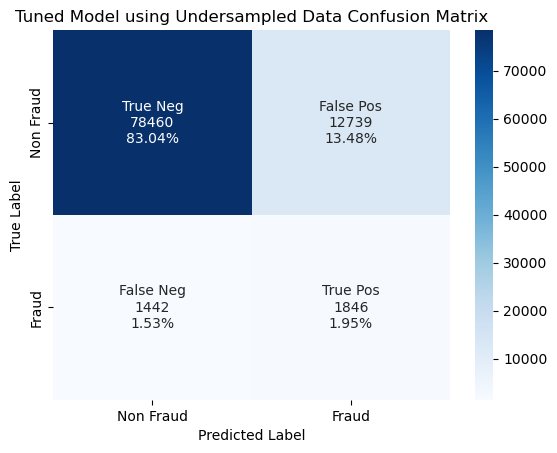

Metrics when threshold is 0.57: 

False Positive Rate: 0.13968354916172326
Recall: 0.5614355231143552
Precision: 0.12656839218375043
Accuracy: 0.8499158614412564
F1: 0.20656856711240415
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.58


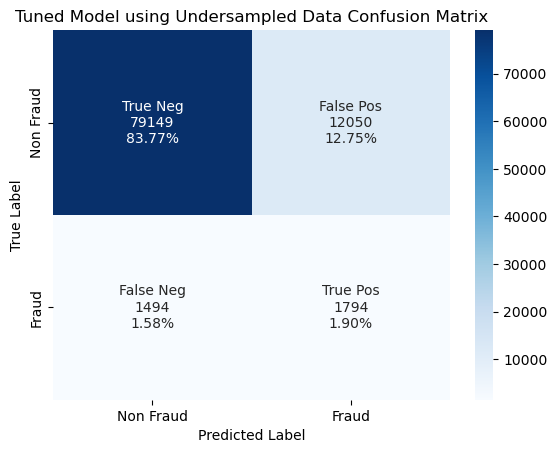

Metrics when threshold is 0.58: 

False Positive Rate: 0.13212864176142283
Recall: 0.5456204379562044
Precision: 0.12958682461716267
Accuracy: 0.8566575296072475
F1: 0.2094326406724259
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.59


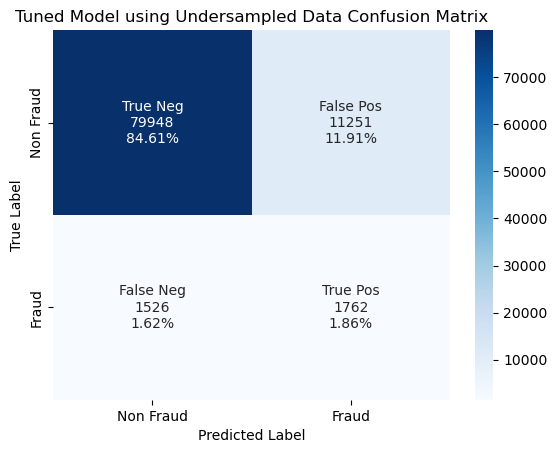

Metrics when threshold is 0.59: 

False Positive Rate: 0.12336758078487703
Recall: 0.5358880778588808
Precision: 0.13540305847998155
Accuracy: 0.8647750484193593
F1: 0.21618305625421752
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.6


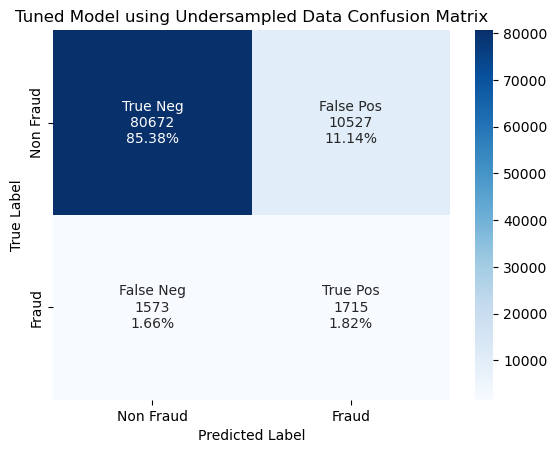

Metrics when threshold is 0.6: 

False Positive Rate: 0.11542889724668033
Recall: 0.5215936739659367
Precision: 0.14009148831890214
Accuracy: 0.8719400552456952
F1: 0.22086284610431423
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.61


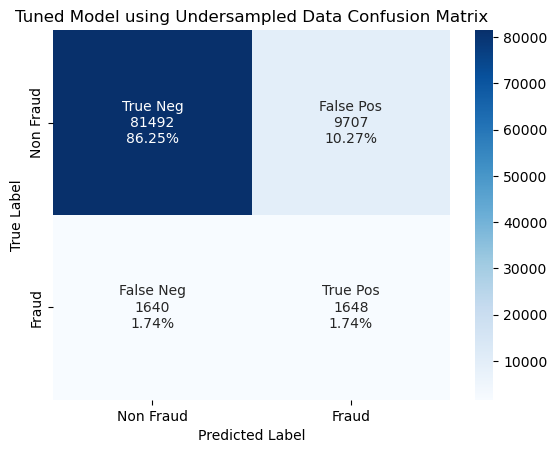

Metrics when threshold is 0.61: 

False Positive Rate: 0.1064375705873968
Recall: 0.5012165450121655
Precision: 0.14513430206957287
Accuracy: 0.8799094055266862
F1: 0.2250904869220788
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.62


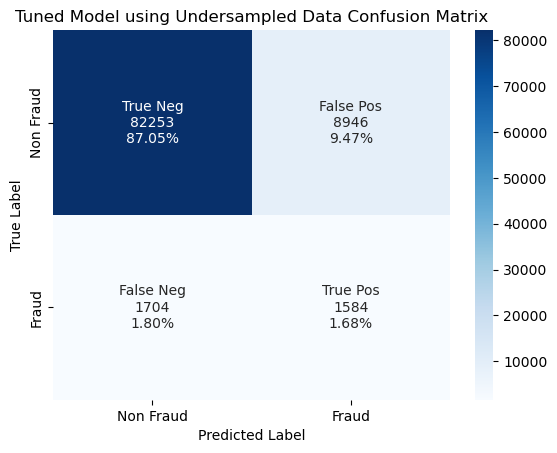

Metrics when threshold is 0.62: 

False Positive Rate: 0.09809318084628121
Recall: 0.48175182481751827
Precision: 0.15042735042735042
Accuracy: 0.8872860816831946
F1: 0.22926617455492837
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.63


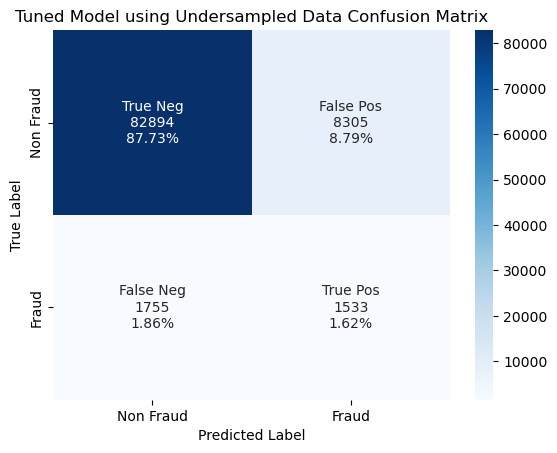

Metrics when threshold is 0.63: 

False Positive Rate: 0.0910645950065242
Recall: 0.46624087591240876
Precision: 0.15582435454360644
Accuracy: 0.8935303269232805
F1: 0.23358220326070395
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.64


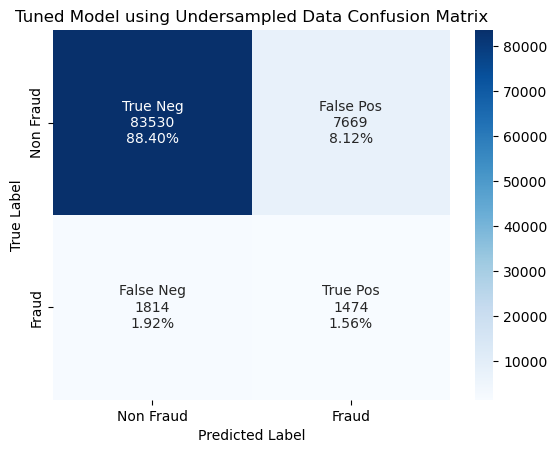

Metrics when threshold is 0.64: 

False Positive Rate: 0.08409083432932378
Recall: 0.44829683698296835
Precision: 0.16121623099639068
Accuracy: 0.8996369870987543
F1: 0.23714906282680398
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.65


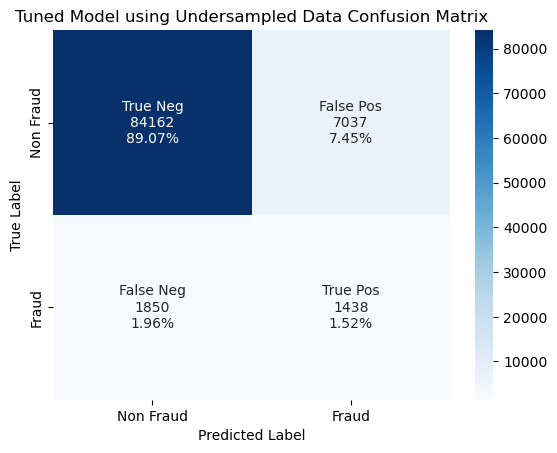

Metrics when threshold is 0.65: 

False Positive Rate: 0.07716093378216866
Recall: 0.4373479318734793
Precision: 0.16967551622418878
Accuracy: 0.905944733137892
F1: 0.24449545184051685
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.66


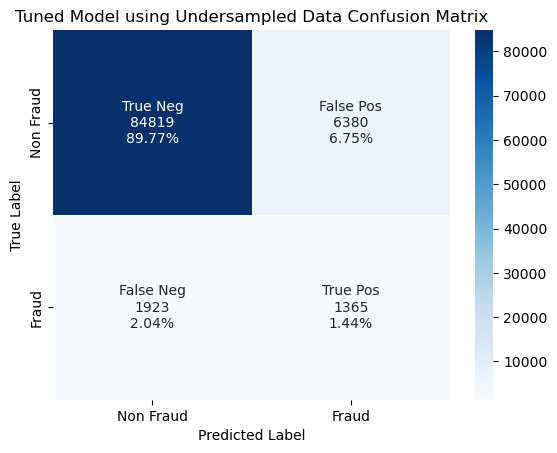

Metrics when threshold is 0.66: 

False Positive Rate: 0.06995690742223051
Recall: 0.41514598540145986
Precision: 0.1762427372498386
Accuracy: 0.9121254775789261
F1: 0.24743949968276985
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.67


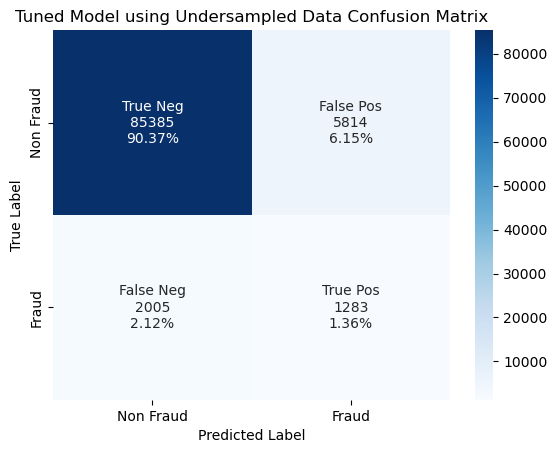

Metrics when threshold is 0.67: 

False Positive Rate: 0.0637506990208226
Recall: 0.39020681265206814
Precision: 0.1807806115259969
Accuracy: 0.9172478753690984
F1: 0.24708714492055847
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.68


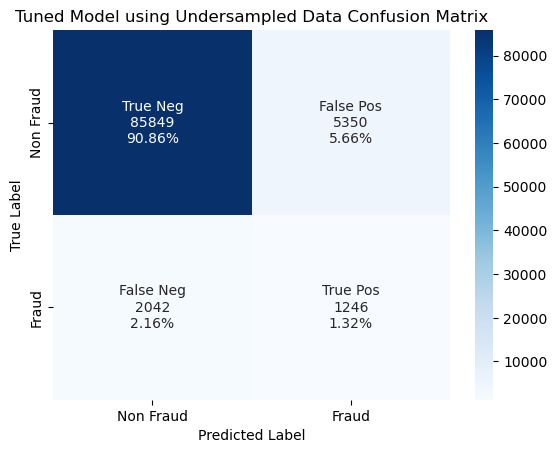

Metrics when threshold is 0.68: 

False Positive Rate: 0.05866292393556947
Recall: 0.3789537712895377
Precision: 0.18890236506973923
Accuracy: 0.9217670155682792
F1: 0.2521246458923513
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.69


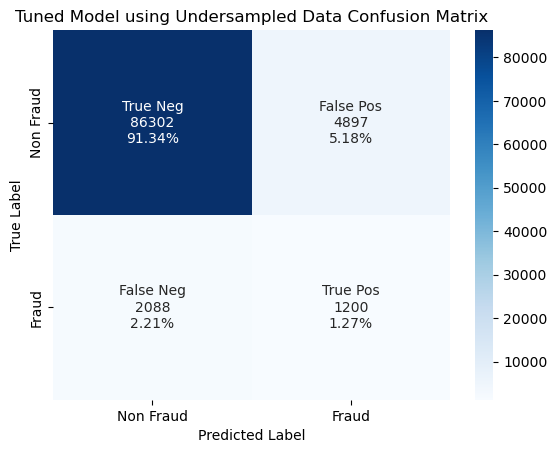

Metrics when threshold is 0.69: 

False Positive Rate: 0.05369576420794088
Recall: 0.36496350364963503
Precision: 0.19681810726586846
Accuracy: 0.9260744864372876
F1: 0.25572722429408634
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726
Threshold: 0.7


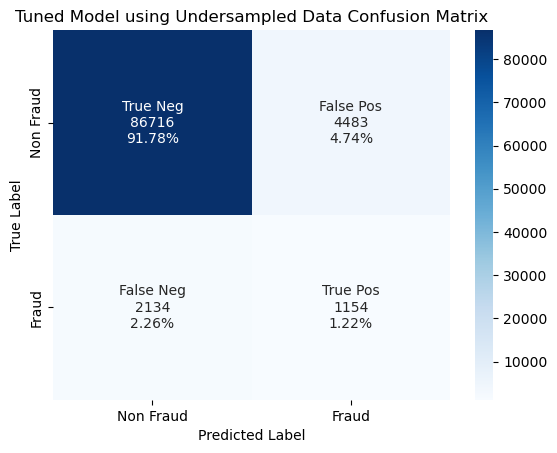

Metrics when threshold is 0.7: 

False Positive Rate: 0.04915624074825382
Recall: 0.35097323600973235
Precision: 0.20471882206847614
Accuracy: 0.9299692021124599
F1: 0.2585994397759103
AUC: 0.8014763672601845
Average Precision Score: 0.17605269449105726


In [107]:
threshold = threshold = np.round(np.arange(0.3, 0.71, 0.01), 2)
results = []

for thresh in threshold:
    print(f"Threshold: {thresh}")
    y_pred_binary_rus = (y_pred_rus > thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_binary_rus)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.title("Tuned Model using Undersampled Data Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    ax.yaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = (2 * recall * precision) / (recall + precision)
    avg_prec_score_rus = average_precision_score(y_test, y_pred_rus)

    print(f"Metrics when threshold is {thresh}: ")
    print()
    print(f"False Positive Rate: {fpr}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1}")
    print(f"AUC: {auc_keras_rus}")
    print(f"Average Precision Score: {avg_prec_score_rus}")
    print("="*80)

    result = {
        'Threshold': thresh,
        'False Positive Rate': fpr,
        'Recall': recall,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1,
        'AUC': auc_keras_rus,
        'Avg Precision Score': avg_prec_score_rus
    }
    results.append(result)

df_result_rus = pd.DataFrame(results)

In [108]:
df_result_rus

Threshold  False Positive Rate    Recall  Precision  Accuracy        F1   
0        0.30             0.626443  0.928528   0.050728  0.392869  0.096200  \
1        0.31             0.617013  0.925791   0.051319  0.401875  0.097248   
2        0.32             0.607485  0.923054   0.051936  0.410977  0.098339   
3        0.33             0.592835  0.919708   0.052969  0.425000  0.100169   
4        0.34             0.569085  0.913017   0.054679  0.447691  0.103179   
5        0.35             0.546881  0.906934   0.056416  0.468911  0.106225   
6        0.36             0.527429  0.899635   0.057933  0.487432  0.108856   
7        0.37             0.513975  0.893248   0.058963  0.500196  0.110624   
8        0.38             0.501299  0.886861   0.059958  0.512208  0.112322   
9        0.39             0.487418  0.877129   0.060926  0.525268  0.113938   
10       0.40             0.468854  0.864659   0.062344  0.542752  0.116302   
11       0.41             0.443163  0.845803   0.064379  0.566893  0.119652   
12       0.42             0.421430  0.831813   0.066433  0.587382  0.123040   
13       0.43             0.386090  0.809002   0.070238  0.620699  0.129255   
14       0.44             0.332855  0.768248   0.076820  0.670664  0.139674   
15       0.45             0.290705  0.735097   0.083549  0.710193  0.150045   
16       0.46             0.261121  0.711983   0.089505  0.737943  0.159019   
17       0.47             0.243172  0.690998   0.092928  0.754538  0.163824   
18       0.48             0.231000  0.676095   0.095449  0.765767  0.167281   
19       0.49             0.214301  0.663929   0.100474  0.781462  0.174535   
20       0.50             0.204893  0.653589   0.103144  0.790183  0.178170   
21       0.51             0.197711  0.644465   0.105161  0.796797  0.180817   
22       0.52             0.185748  0.632908   0.109405  0.807942  0.186561   
23       0.53             0.174826  0.618005   0.113040  0.817964  0.191121   
24       0.54             0.164388  0.600669   0.116402  0.827437  0.195014   
25       0.55             0.154914  0.588200   0.120408  0.836147  0.199897   
26       0.56             0.147370  0.576642   0.123631  0.843026  0.203608   
27       0.57             0.139684  0.561436   0.126568  0.849916  0.206569   
28       0.58             0.132129  0.545620   0.129587  0.856658  0.209433   
29       0.59             0.123368  0.535888   0.135403  0.864775  0.216183   
30       0.60             0.115429  0.521594   0.140091  0.871940  0.220863   
31       0.61             0.106438  0.501217   0.145134  0.879909  0.225090   
32       0.62             0.098093  0.481752   0.150427  0.887286  0.229266   
33       0.63             0.091065  0.466241   0.155824  0.893530  0.233582   
34       0.64             0.084091  0.448297   0.161216  0.899637  0.237149   
35       0.65             0.077161  0.437348   0.169676  0.905945  0.244495   
36       0.66             0.069957  0.415146   0.176243  0.912125  0.247439   
37       0.67             0.063751  0.390207   0.180781  0.917248  0.247087   
38       0.68             0.058663  0.378954   0.188902  0.921767  0.252125   
39       0.69             0.053696  0.364964   0.196818  0.926074  0.255727   
40       0.70             0.049156  0.350973   0.204719  0.929969  0.258599   

         AUC  Avg Precision Score  
0   0.801476             0.176053  
1   0.801476             0.176053  
2   0.801476             0.176053  
3   0.801476             0.176053  
4   0.801476             0.176053  
5   0.801476             0.176053  
6   0.801476             0.176053  
7   0.801476             0.176053  
8   0.801476             0.176053  
9   0.801476             0.176053  
10  0.801476             0.176053  
11  0.801476             0.176053  
12  0.801476             0.176053  
13  0.801476             0.176053  
14  0.801476             0.176053  
15  0.801476             0.176053  
16  0.801476             0.176053  
17  0.801476             0.176053  
1

In [109]:
df_result_smote

Threshold  False Positive Rate    Recall  Precision  Accuracy        F1   
0        0.30             0.457889  0.867397   0.063930  0.553431  0.119084  \
1        0.31             0.440038  0.858881   0.065743  0.570364  0.122137   
2        0.32             0.424445  0.850973   0.067410  0.585139  0.124925   
3        0.33             0.408656  0.841545   0.069113  0.600051  0.127735   
4        0.34             0.390772  0.832725   0.071347  0.617006  0.131432   
5        0.35             0.374094  0.824209   0.073587  0.632807  0.135112   
6        0.36             0.352646  0.812348   0.076682  0.653095  0.140136   
7        0.37             0.335234  0.802007   0.079404  0.669542  0.144501   
8        0.38             0.317175  0.789842   0.082384  0.686549  0.149206   
9        0.39             0.296297  0.775547   0.086230  0.706203  0.155204   
10       0.40             0.277722  0.760341   0.089838  0.723602  0.160689   
11       0.41             0.260080  0.744526   0.093553  0.740081  0.166220   
12       0.42             0.239136  0.729015   0.099025  0.759755  0.174365   
13       0.43             0.225638  0.715937   0.102651  0.772328  0.179558   
14       0.44             0.209750  0.699818   0.107373  0.787103  0.186180   
15       0.45             0.192425  0.680049   0.113015  0.803137  0.193820   
16       0.46             0.182217  0.664538   0.116205  0.812450  0.197818   
17       0.47             0.170495  0.650547   0.120929  0.823277  0.203947   
18       0.48             0.161361  0.636557   0.124517  0.831606  0.208290   
19       0.49             0.153434  0.625912   0.128216  0.838888  0.212834   
20       0.50             0.143774  0.613443   0.133320  0.847778  0.219037   
21       0.51             0.137600  0.603406   0.136517  0.853387  0.222659   
22       0.52             0.130791  0.592153   0.140324  0.859568  0.226883   
23       0.53             0.124519  0.585158   0.144880  0.865378  0.232255   
24       0.54             0.118313  0.576034   0.149322  0.871051  0.237165   
25       0.55             0.111778  0.565389   0.154235  0.876988  0.242357   
26       0.56             0.105802  0.557786   0.159714  0.882492  0.248324   
27       0.57             0.100714  0.551399   0.164848  0.887180  0.253815   
28       0.58             0.095352  0.541058   0.169833  0.891996  0.258519   
29       0.59             0.090056  0.531022   0.175319  0.896758  0.263607   
30       0.60             0.085626  0.519161   0.179382  0.900621  0.266635   
31       0.61             0.080746  0.506387   0.184406  0.904886  0.270358   
32       0.62             0.076909  0.500304   0.189976  0.908379  0.275383   
33       0.63             0.073279  0.491788   0.194819  0.911586  0.279082   
34       0.64             0.069584  0.481144   0.199546  0.914782  0.282097   
35       0.65             0.066207  0.474148   0.205213  0.917798  0.286449   
36       0.66             0.063071  0.467153   0.210757  0.920582  0.290469   
37       0.67             0.060527  0.459550   0.214905  0.922772  0.292858   
38       0.68             0.057797  0.453467   0.220497  0.925196  0.296716   
39       0.69             0.054968  0.446168   0.226389  0.927673  0.300369   
40       0.70             0.052643  0.436740   0.230239  0.929588  0.301522   

         AUC  Avg Precision Score  
0   0.821032             0.268151  
1   0.821032             0.268151  
2   0.821032             0.268151  
3   0.821032             0.268151  
4   0.821032             0.268151  
5   0.821032             0.268151  
6   0.821032             0.268151  
7   0.821032             0.268151  
8   0.821032             0.268151  
9   0.821032             0.268151  
10  0.821032             0.268151  
11  0.821032             0.268151  
12  0.821032             0.268151  
13  0.821032             0.268151  
14  0.821032             0.268151  
15  0.821032             0.268151  
16  0.821032             0.268151  
17  0.821032             0.268151  
1

In [110]:
df_result_rus.to_csv('hasil threshold undersampled.csv')
df_result_smote.to_csv('hasil threshold smote.csv')

In [73]:
smote_xtest_output = temp_smote[['predicted', 'true']]
smote_xtest_output.to_csv('smote_xtest_output.csv', index=False)

In [74]:
rus_xtest_output = temp_rus[['predicted', 'true']]
rus_xtest_output.to_csv('rus_xtest_output.csv', index=False)

In [76]:
y_pred_train_rus = model_rus.predict(X_train)
y_pred_train_smote = model_smote.predict(X_train)

11811/11811 [==============================] - 16s 1ms/step


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [77]:
temp_train_rus = X_train.copy()
temp_train_rus['predicted'] = y_pred_train_rus
temp_train_rus['true'] = y_train

rus_xtrain_output = temp_train_rus[['predicted', 'true']]

temp_train_smote = X_train.copy()
temp_train_smote['predicted'] = y_pred_train_smote
temp_train_smote['true'] = y_train

smote_xtrain_output = temp_train_smote[['predicted', 'true']]

In [81]:
rus_xtrain_output.to_csv('rus_xtrain_output.csv', index=False)
smote_xtrain_output.to_csv('smote_xtrain_output.csv', index=False)